In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##**Libraries**

In [3]:
# Install required libraries
!pip install transformers scikit-learn datasets shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


##**Load and Preprocess Data**

##**SVM**

##**Jokes-only GPT**

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the basic dataset
df_basic = pd.read_csv("/content/drive/MyDrive/DSF Project/chatgptfromscratch.csv")  # Replace with correct file path

# Map 'Classification' column to numeric labels (NSFW: 1, SFW: 0)
df_basic['label'] = df_basic['Classification'].map({'NSFW': 1, 'SFW': 0})  # Creating 'label' column

# Check for missing values in the label column
if df_basic['label'].isnull().any():
    print("Some rows have missing labels. Please check the dataset.")
    print(df_basic[df_basic['label'].isnull()])
    raise ValueError("Missing labels found in dataset!")

# Feature Engineering: Sentiment and Word Count
from textblob import TextBlob

df_basic['Sentiment'] = df_basic['Jokes'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_basic['Word_Count'] = df_basic['Jokes'].apply(lambda x: len(x.split()))

# Split data into features and labels
X_basic = df_basic[['Jokes', 'Sentiment', 'Word_Count']]
y_basic = df_basic['label']

# Train-test split
X_train_basic, X_test_basic, y_train_basic, y_test_basic = train_test_split(
    X_basic, y_basic, test_size=0.3, stratify=y_basic, random_state=42
)


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

# Custom vectorizer combining TF-IDF and additional features
class CustomVectorizer:
    def __init__(self, max_features=3333):
        self.vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')

    def fit(self, X, y=None):
        self.vectorizer.fit(X['Jokes'])
        return self

    def transform(self, X):
        tfidf_matrix = self.vectorizer.transform(X['Jokes']).toarray()
        additional_features = X[['Sentiment', 'Word_Count']].values
        return np.hstack((tfidf_matrix, additional_features))

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

# Create pipeline
pipeline_basic = Pipeline([
    ('vectorizer', CustomVectorizer(max_features=3333)),  # TF-IDF with 3000 features
    ('svm', SVC(kernel='linear', class_weight='balanced', C=0.5, random_state=42, probability=True))  # SVM settings
])

# Train the model
pipeline_basic.fit(X_train_basic, y_train_basic)

# Evaluate the model
train_preds_basic = pipeline_basic.predict(X_train_basic)
test_preds_basic = pipeline_basic.predict(X_test_basic)

train_accuracy_basic = accuracy_score(y_train_basic, train_preds_basic)
test_accuracy_basic = accuracy_score(y_test_basic, test_preds_basic)

print("Train Accuracy (Basic Dataset): {:.2f}%".format(train_accuracy_basic * 100))
print("Test Accuracy (Basic Dataset): {:.2f}%".format(test_accuracy_basic * 100))

# Classification Report
print("\nClassification Report on Basic Dataset Test Data:\n")
print(classification_report(y_test_basic, test_preds_basic))

# Cross-Validation
print("\nCross-Validation Results (Basic Dataset):")
cv_scores_basic = cross_val_score(pipeline_basic, X_train_basic, y_train_basic, cv=5, scoring='accuracy')
print("Mean Cross-Validation Accuracy: {:.2f}%".format(cv_scores_basic.mean() * 100))
print("Standard Deviation: {:.2f}%".format(cv_scores_basic.std() * 100))


Train Accuracy (Basic Dataset): 99.71%
Test Accuracy (Basic Dataset): 99.00%

Classification Report on Basic Dataset Test Data:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1500
           1       1.00      0.98      0.99      1500

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000


Cross-Validation Results (Basic Dataset):
Mean Cross-Validation Accuracy: 98.90%
Standard Deviation: 0.14%


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, log_loss, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

# Custom vectorizer combining TF-IDF and additional features
class CustomVectorizer:
    def __init__(self, max_features=3333):
        self.vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')

    def fit(self, X, y=None):
        self.vectorizer.fit(X['Jokes'])
        return self

    def transform(self, X):
        tfidf_matrix = self.vectorizer.transform(X['Jokes']).toarray()
        additional_features = X[['Sentiment', 'Word_Count']].values
        return np.hstack((tfidf_matrix, additional_features))

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

# Create pipeline
pipeline_basic = Pipeline([
    ('vectorizer', CustomVectorizer(max_features=3333)),  # TF-IDF with 3333 features
    ('svm', SVC(kernel='linear', class_weight='balanced', C=0.5, random_state=42, probability=True))  # SVM settings
])

# Train the model
pipeline_basic.fit(X_train_basic, y_train_basic)

# Predictions and Probabilities
train_preds_basic = pipeline_basic.predict(X_train_basic)
test_preds_basic = pipeline_basic.predict(X_test_basic)
train_probs_basic = pipeline_basic.predict_proba(X_train_basic)
test_probs_basic = pipeline_basic.predict_proba(X_test_basic)

# Metrics Calculation: Training
train_accuracy_basic = accuracy_score(y_train_basic, train_preds_basic)
train_loss_basic = log_loss(y_train_basic, train_probs_basic)
train_precision = precision_score(y_train_basic, train_preds_basic)
train_recall = recall_score(y_train_basic, train_preds_basic)
train_f1 = f1_score(y_train_basic, train_preds_basic)

# Metrics Calculation: Testing
test_accuracy_basic = accuracy_score(y_test_basic, test_preds_basic)
test_loss_basic = log_loss(y_test_basic, test_probs_basic)
test_precision = precision_score(y_test_basic, test_preds_basic)
test_recall = recall_score(y_test_basic, test_preds_basic)
test_f1 = f1_score(y_test_basic, test_preds_basic)

# Output Training Metrics
print("\nTraining Metrics:")
print(f"Accuracy: {train_accuracy_basic:.4f}")
print(f"Loss: {train_loss_basic:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")

# Output Testing Metrics
print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy_basic:.4f}")
print(f"Loss: {test_loss_basic:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")

# Classification Reports
print("\nClassification Report (Training):")
print(classification_report(y_train_basic, train_preds_basic))
print("\nClassification Report (Testing):")
print(classification_report(y_test_basic, test_preds_basic))

# Cross-Validation
print("\nCross-Validation Results (Basic Dataset):")
cv_scores_basic = cross_val_score(pipeline_basic, X_train_basic, y_train_basic, cv=5, scoring='accuracy')
print(f"Mean Cross-Validation Accuracy: {cv_scores_basic.mean():.4f}")
print(f"Standard Deviation: {cv_scores_basic.std():.4f}")



Training Metrics:
Accuracy: 0.9971
Loss: 0.0098
Precision: 0.9991
Recall: 0.9951
F1-Score: 0.9971

Testing Metrics:
Accuracy: 0.9900
Loss: 0.0244
Precision: 0.9953
Recall: 0.9847
F1-Score: 0.9899

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3500
           1       1.00      1.00      1.00      3500

    accuracy                           1.00      7000
   macro avg       1.00      1.00      1.00      7000
weighted avg       1.00      1.00      1.00      7000


Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1500
           1       1.00      0.98      0.99      1500

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000


Cross-Validation Results (Basic Dataset):
Mean Cross-Validation Accuracy: 0.989

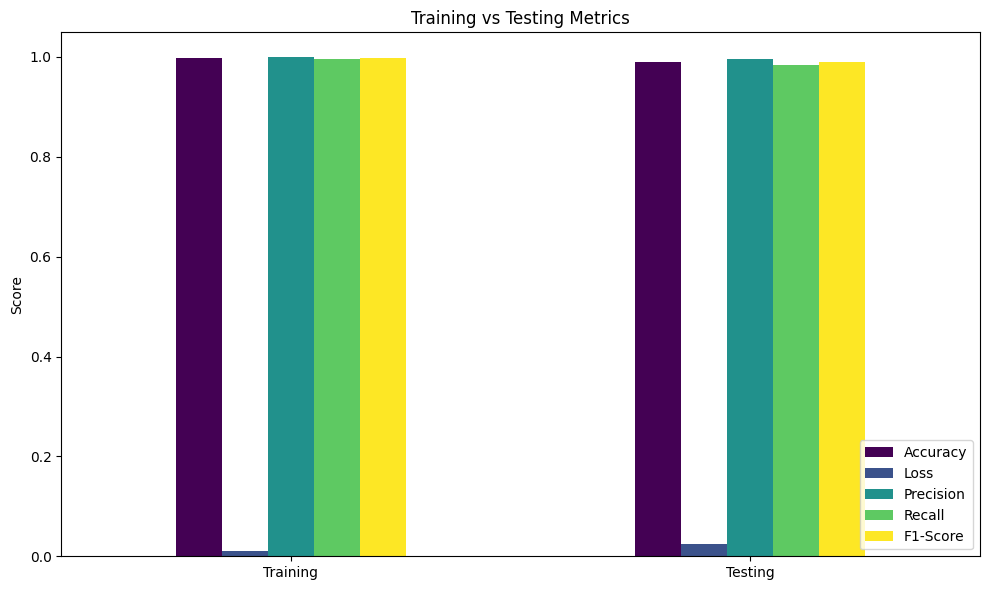

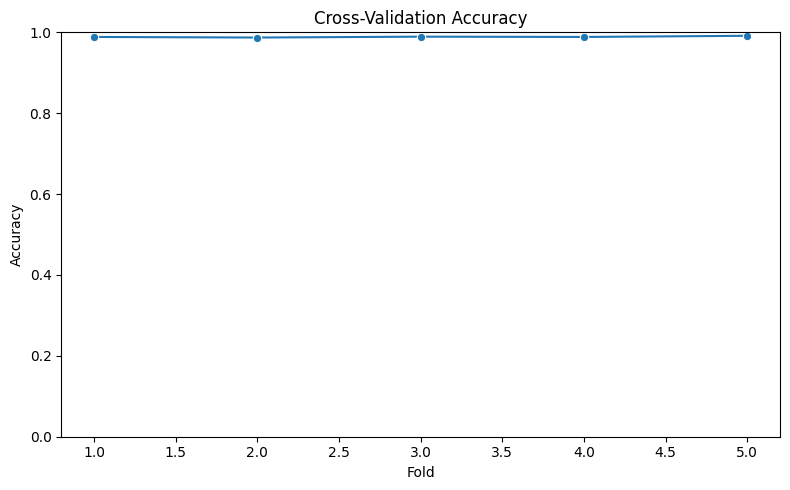

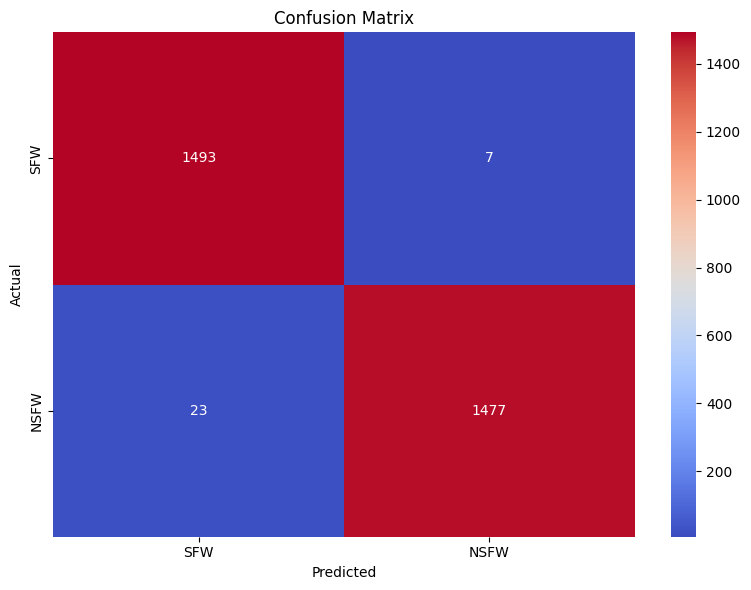

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Training and Testing Metrics
metrics = {
    "Accuracy": [train_accuracy_basic, test_accuracy_basic],
    "Loss": [train_loss_basic, test_loss_basic],
    "Precision": [train_precision, test_precision],
    "Recall": [train_recall, test_recall],
    "F1-Score": [train_f1, test_f1],
}

# Convert metrics into a DataFrame for visualization
import pandas as pd
metrics_df = pd.DataFrame(metrics, index=["Training", "Testing"])

# Plot Accuracy, Loss, Precision, Recall, F1-Score
metrics_df.plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Training vs Testing Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Cross-Validation Accuracy Visualization
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, 6), y=cv_scores_basic, marker="o")
plt.title("Cross-Validation Accuracy")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Classification Report Heatmap (Testing)
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_basic, test_preds_basic)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=["SFW", "NSFW"], yticklabels=["SFW", "NSFW"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, log_loss
from textblob import TextBlob

# Load datasets
train_df = pd.read_csv("/content/drive/MyDrive/DSF Project/chatgptfromscratch.csv")  # Scratch data file
test_df = pd.read_csv("/content/drive/MyDrive/DSF Project/random_10000_jokes.csv")  # Random jokes file

# Ensure unique test data by removing overlapping jokes
train_jokes = train_df['Jokes'].unique()  # 'Jokes' column in the training data
test_df_unique = test_df[~test_df['jokes'].isin(train_jokes)].copy()  # 'jokes' column in the test data

# Limit the test data size to 1500 rows
test_df_unique = test_df_unique.sample(n=1500, random_state=42)

# Preprocess training data
train_df['label'] = train_df['Classification'].map({'NSFW': 1, 'SFW': 0})  # Map to binary labels
train_df['Sentiment'] = train_df['Jokes'].apply(lambda x: TextBlob(x).sentiment.polarity)
train_df['Word_Count'] = train_df['Jokes'].apply(lambda x: len(x.split()))

# Preprocess test data
test_df_unique['label'] = test_df_unique['classification'].map({'NSFW': 1, 'SFW': 0})  # Map to binary labels
test_df_unique['Sentiment'] = test_df_unique['jokes'].apply(lambda x: TextBlob(x).sentiment.polarity)
test_df_unique['Word_Count'] = test_df_unique['jokes'].apply(lambda x: len(x.split()))

# Prepare features and labels for training and testing
X_train = train_df[['Jokes', 'Sentiment', 'Word_Count']]  # Training data columns
y_train = train_df['label']

X_test = test_df_unique[['jokes', 'Sentiment', 'Word_Count']]  # Test data columns
y_test = test_df_unique['label']

# Custom vectorizer combining TF-IDF and additional features
class CustomVectorizer:
    def __init__(self, max_features=3333):
        self.vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')

    def fit(self, X, y=None):
        self.vectorizer.fit(X['Jokes'])  # Use 'Jokes' for training
        return self

    def transform(self, X):
        tfidf_matrix = self.vectorizer.transform(X['Jokes']).toarray() if 'Jokes' in X else self.vectorizer.transform(X['jokes']).toarray()
        additional_features = X[['Sentiment', 'Word_Count']].values
        return np.hstack((tfidf_matrix, additional_features))

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

# Create pipeline
pipeline = Pipeline([
    ('vectorizer', CustomVectorizer(max_features=3333)),  # TF-IDF with 3333 features
    ('svm', SVC(kernel='linear', class_weight='balanced', C=0.5, random_state=42, probability=True))  # SVM settings
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions and Probabilities
train_preds = pipeline.predict(X_train)
test_preds = pipeline.predict(X_test)

train_probs = pipeline.predict_proba(X_train)
test_probs = pipeline.predict_proba(X_test)

# Metrics Calculation
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

train_loss = log_loss(y_train, train_probs)
test_loss = log_loss(y_test, test_probs)

train_classification_report = classification_report(y_train, train_preds, output_dict=True)
test_classification_report = classification_report(y_test, test_preds, output_dict=True)

# Report Metrics
print("Training Metrics:")
print(f"Loss: {train_loss:.4f}")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_classification_report['weighted avg']['precision']:.4f}")
print(f"Recall: {train_classification_report['weighted avg']['recall']:.4f}")
print(f"F1-Score: {train_classification_report['weighted avg']['f1-score']:.4f}")

print("\nTesting Metrics:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_classification_report['weighted avg']['precision']:.4f}")
print(f"Recall: {test_classification_report['weighted avg']['recall']:.4f}")
print(f"F1-Score: {test_classification_report['weighted avg']['f1-score']:.4f}")


Training Metrics:
Loss: 0.0084
Accuracy: 0.9970
Precision: 0.9970
Recall: 0.9970
F1-Score: 0.9970

Testing Metrics:
Loss: 4.5445
Accuracy: 0.6273
Precision: 0.6246
Recall: 0.6273
F1-Score: 0.6259


##**Jokes GPT Augmeneted**

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Load synthetic dataset
df = pd.read_csv("/content/drive/MyDrive/DSF Project/jokes copy (1).csv")  # Replace with your dataset path

# Map 'Classification' column to numeric labels (NSFW: 1, SFW: 0)
df['label'] = df['Classification'].map({'NSFW': 1, 'SFW': 0})  # Creating 'label' column for model

# Check for missing values in the label column
if df['label'].isnull().any():
    print("Some rows have missing labels. Please check the dataset.")
    print(df[df['label'].isnull()])
    raise ValueError("Missing labels found in dataset!")

# Split into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['Joke'], df['label'], test_size=0.3, stratify=df['label'], random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Convert to Hugging Face Dataset format
train_data = Dataset.from_dict({'text': train_texts.tolist(), 'label': train_labels.tolist()})
val_data = Dataset.from_dict({'text': val_texts.tolist(), 'label': val_labels.tolist()})
test_data = Dataset.from_dict({'text': test_texts.tolist(), 'label': test_labels.tolist()})

print("Data successfully processed and split!")


Data successfully processed and split!



Training Metrics:
Accuracy: 0.8141
Loss: 0.4261

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.75      0.89      0.81      4569
           1       0.89      0.75      0.82      5431

    accuracy                           0.81     10000
   macro avg       0.82      0.82      0.81     10000
weighted avg       0.83      0.81      0.81     10000


Testing Metrics:
Accuracy: 0.7707
Loss: 0.4946

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.53      0.59      0.56       366
           1       0.86      0.83      0.85      1134

    accuracy                           0.77      1500
   macro avg       0.69      0.71      0.70      1500
weighted avg       0.78      0.77      0.78      1500


Cross-Validation Results:
Mean Cross-Validation Accuracy: 0.6993
Standard Deviation: 0.0099


<Figure size 1000x600 with 0 Axes>

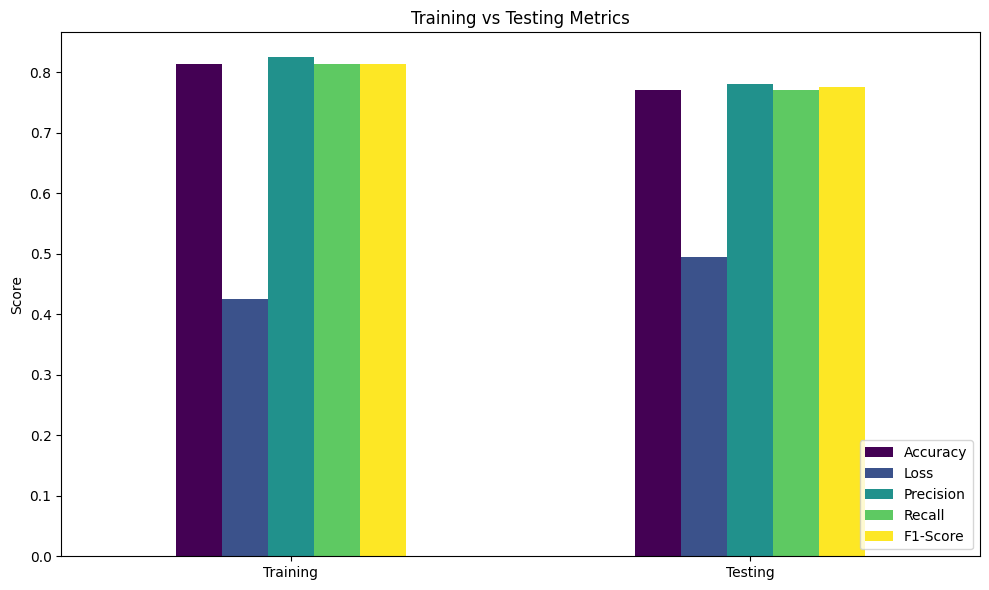

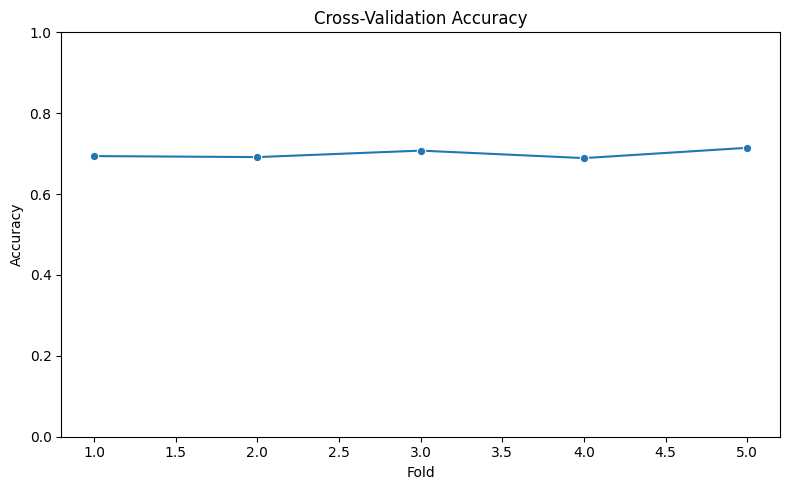

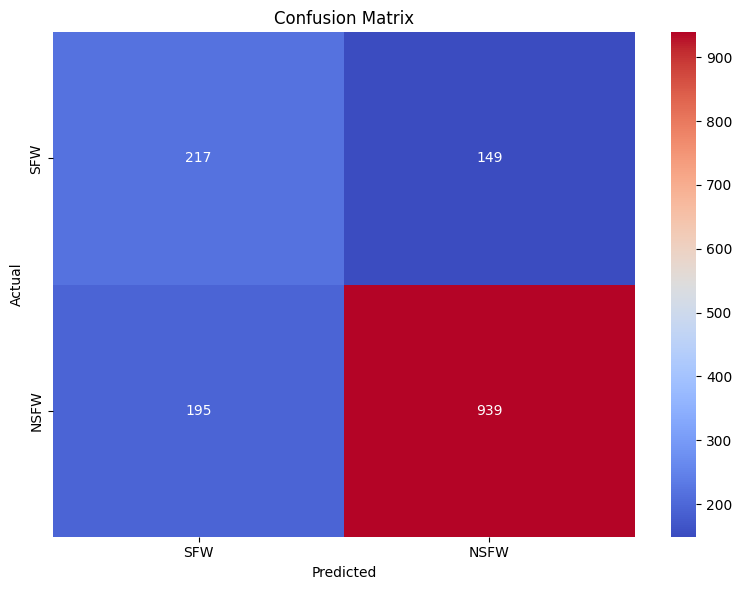

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, log_loss, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

# Load datasets
train_df = pd.read_csv("/content/drive/MyDrive/DSF Project/jokes copy (1).csv")  # Training data file
test_df = pd.read_csv("/content/drive/MyDrive/DSF Project/random_10000_jokes.csv")  # Random test data file

# Ensure unique test data by removing overlapping jokes
train_jokes = train_df['Joke'].unique()
test_df_unique = test_df[~test_df['jokes'].isin(train_jokes)].copy()

# Limit the test data size to 1200-1800 rows
test_df_unique = test_df_unique.sample(n=1500, random_state=42)

# Preprocess training data
train_df['label'] = train_df['Classification'].map({'NSFW': 1, 'SFW': 0})  # Map to binary labels
train_df['Sentiment'] = train_df['Joke'].apply(lambda x: TextBlob(x).sentiment.polarity)
train_df['Word_Count'] = train_df['Joke'].apply(lambda x: len(x.split()))

# Preprocess test data
test_df_unique['label'] = test_df_unique['classification'].map({'NSFW': 1, 'SFW': 0})  # Map to binary labels
test_df_unique['Sentiment'] = test_df_unique['jokes'].apply(lambda x: TextBlob(x).sentiment.polarity)
test_df_unique['Word_Count'] = test_df_unique['jokes'].apply(lambda x: len(x.split()))

# Prepare features and labels for training and testing
X_train = train_df[['Joke', 'Sentiment', 'Word_Count']]
y_train = train_df['label']

X_test = test_df_unique[['jokes', 'Sentiment', 'Word_Count']]
y_test = test_df_unique['label']

# Define custom vectorizer to combine TF-IDF and additional features
class CustomVectorizer:
    def __init__(self, max_features=3333):
        self.vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')

    def fit(self, X, y=None):
        self.vectorizer.fit(X['Joke'] if 'Joke' in X.columns else X['jokes'])
        return self

    def transform(self, X):
        tfidf_matrix = self.vectorizer.transform(X['Joke'] if 'Joke' in X.columns else X['jokes']).toarray()
        additional_features = X[['Sentiment', 'Word_Count']].values
        return np.hstack((tfidf_matrix, additional_features))

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

# Create pipeline with revised parameters
pipeline = Pipeline([
    ('vectorizer', CustomVectorizer(max_features=3333)),  # Adjusted max_features
    ('svm', SVC(kernel='linear', class_weight='balanced', C=0.5, random_state=42, probability=True))  # SVM with probability
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions and Probabilities
train_preds = pipeline.predict(X_train)
test_preds = pipeline.predict(X_test)
train_probs = pipeline.predict_proba(X_train)
test_probs = pipeline.predict_proba(X_test)

# Metrics Calculation
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

train_loss = log_loss(y_train, train_probs)
test_loss = log_loss(y_test, test_probs)

train_classification_report = classification_report(y_train, train_preds, output_dict=True)
test_classification_report = classification_report(y_test, test_preds, output_dict=True)

# Cross-Validation for stability
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

# Reporting Results
print("\nTraining Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Loss: {train_loss:.4f}")
print("\nClassification Report (Training):")
print(classification_report(y_train, train_preds))

print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Loss: {test_loss:.4f}")
print("\nClassification Report (Testing):")
print(classification_report(y_test, test_preds))

print("\nCross-Validation Results:")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Visualizations
# Metrics for visualization
metrics = {
    "Accuracy": [train_accuracy, test_accuracy],
    "Loss": [train_loss, test_loss],
    "Precision": [train_classification_report["weighted avg"]["precision"], test_classification_report["weighted avg"]["precision"]],
    "Recall": [train_classification_report["weighted avg"]["recall"], test_classification_report["weighted avg"]["recall"]],
    "F1-Score": [train_classification_report["weighted avg"]["f1-score"], test_classification_report["weighted avg"]["f1-score"]],
}

# Convert metrics into a DataFrame for visualization
metrics_df = pd.DataFrame(metrics, index=["Training", "Testing"])

# Bar chart for Training vs Testing Metrics
plt.figure(figsize=(10, 6))
metrics_df.plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Training vs Testing Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Cross-Validation Accuracy Visualization
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, len(cv_scores) + 1), y=cv_scores, marker="o")
plt.title("Cross-Validation Accuracy")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Confusion Matrix Heatmap (Testing)
conf_matrix = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=["SFW", "NSFW"], yticklabels=["SFW", "NSFW"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


##**Jokes-wo-GPT**

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the basic dataset
df_basic = pd.read_csv("/content/drive/MyDrive/DSF Project/jokeswopairs.csv")  # Replace with correct file path

# Map 'Classification' column to numeric labels (NSFW: 1, SFW: 0)
df_basic['label'] = df_basic['Classification'].map({'NSFW': 1, 'SFW': 0})  # Creating 'label' column

# Check for missing values in the label column
if df_basic['label'].isnull().any():
    print("Some rows have missing labels. Please check the dataset.")
    print(df_basic[df_basic['label'].isnull()])
    raise ValueError("Missing labels found in dataset!")

# Feature Engineering: Sentiment and Word Count
from textblob import TextBlob

df_basic['Sentiment'] = df_basic['Joke'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_basic['Word_Count'] = df_basic['Joke'].apply(lambda x: len(x.split()))

# Split data into features and labels
X_basic = df_basic[['Joke', 'Sentiment', 'Word_Count']]
y_basic = df_basic['label']

# Train-test split
X_train_basic, X_test_basic, y_train_basic, y_test_basic = train_test_split(
    X_basic, y_basic, test_size=0.3, stratify=y_basic, random_state=42
)



Training Metrics:
Accuracy: 0.8280
Loss: 0.4223

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      3198
           1       0.90      0.77      0.83      3802

    accuracy                           0.83      7000
   macro avg       0.83      0.83      0.83      7000
weighted avg       0.84      0.83      0.83      7000


Testing Metrics:
Accuracy: 0.6880
Loss: 0.5613

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.63      0.76      0.69      1371
           1       0.75      0.63      0.69      1629

    accuracy                           0.69      3000
   macro avg       0.69      0.69      0.69      3000
weighted avg       0.70      0.69      0.69      3000


Cross-Validation Results:
Mean Cross-Validation Accuracy: 0.6799
Standard Deviation: 0.0135


<Figure size 1000x600 with 0 Axes>

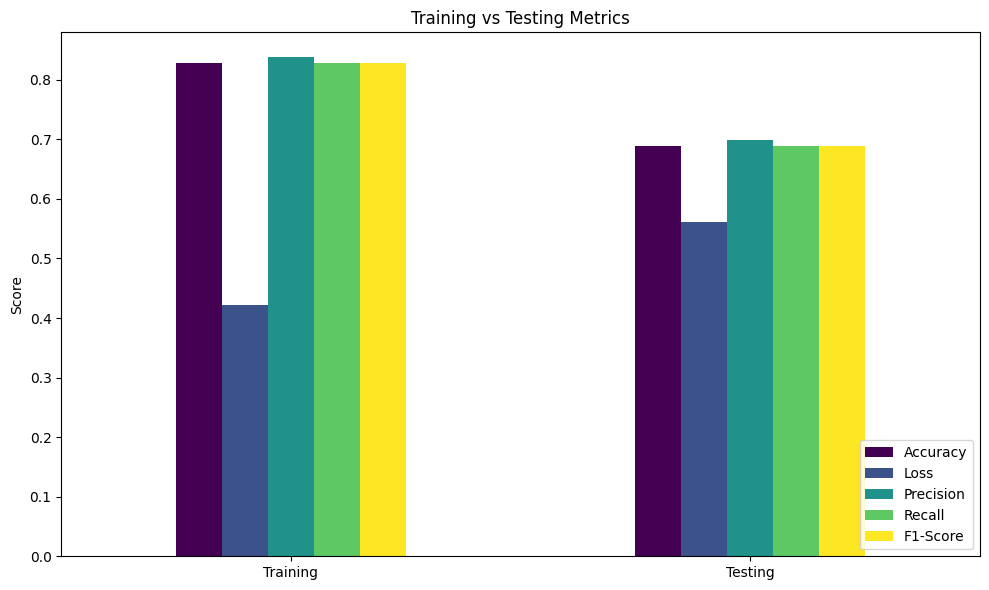

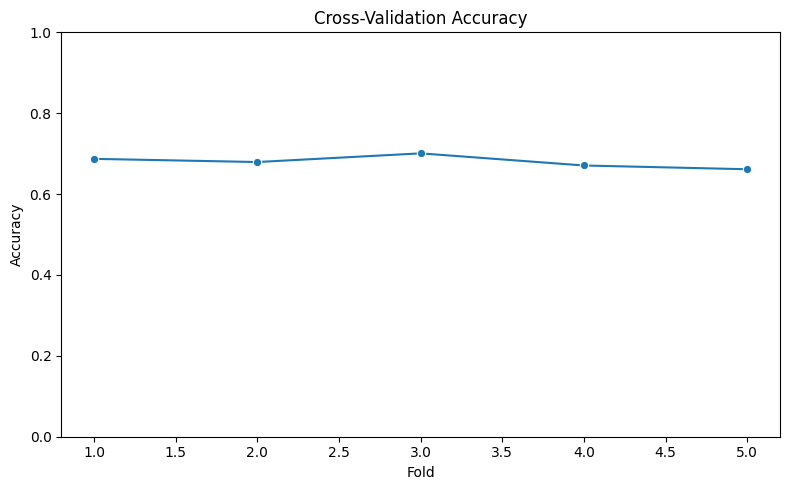

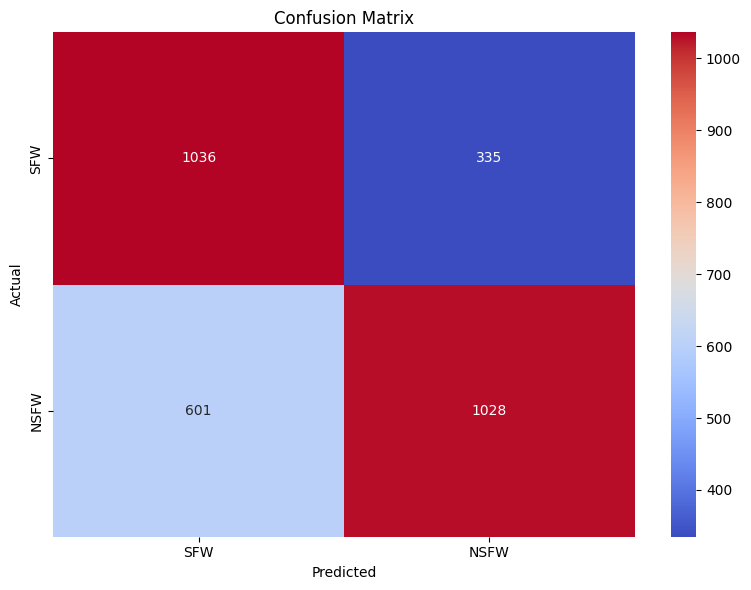

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, log_loss, confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Custom vectorizer combining TF-IDF and additional features
class CustomVectorizer:
    def __init__(self, max_features=3333):
        self.vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')

    def fit(self, X, y=None):
        self.vectorizer.fit(X['Joke'])
        return self

    def transform(self, X):
        tfidf_matrix = self.vectorizer.transform(X['Joke']).toarray()
        additional_features = X[['Sentiment', 'Word_Count']].values
        return np.hstack((tfidf_matrix, additional_features))

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

# Create pipeline
pipeline_basic = Pipeline([
    ('vectorizer', CustomVectorizer(max_features=3333)),  # TF-IDF with 3333 features
    ('svm', SVC(kernel='linear', class_weight='balanced', C=0.5, random_state=42, probability=True))  # SVM settings
])

# Train the model
pipeline_basic.fit(X_train_basic, y_train_basic)

# Predictions and Probabilities
train_preds_basic = pipeline_basic.predict(X_train_basic)
test_preds_basic = pipeline_basic.predict(X_test_basic)
train_probs_basic = pipeline_basic.predict_proba(X_train_basic)
test_probs_basic = pipeline_basic.predict_proba(X_test_basic)

# Metrics Calculation
train_accuracy_basic = accuracy_score(y_train_basic, train_preds_basic)
test_accuracy_basic = accuracy_score(y_test_basic, test_preds_basic)

train_loss_basic = log_loss(y_train_basic, train_probs_basic)
test_loss_basic = log_loss(y_test_basic, test_probs_basic)

train_classification_report_basic = classification_report(y_train_basic, train_preds_basic, output_dict=True)
test_classification_report_basic = classification_report(y_test_basic, test_preds_basic, output_dict=True)

# Cross-Validation
cv_scores_basic = cross_val_score(pipeline_basic, X_train_basic, y_train_basic, cv=5, scoring='accuracy')

# Reporting Results
print("\nTraining Metrics:")
print(f"Accuracy: {train_accuracy_basic:.4f}")
print(f"Loss: {train_loss_basic:.4f}")
print("\nClassification Report (Training):")
print(classification_report(y_train_basic, train_preds_basic))

print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy_basic:.4f}")
print(f"Loss: {test_loss_basic:.4f}")
print("\nClassification Report (Testing):")
print(classification_report(y_test_basic, test_preds_basic))

print("\nCross-Validation Results:")
print(f"Mean Cross-Validation Accuracy: {cv_scores_basic.mean():.4f}")
print(f"Standard Deviation: {cv_scores_basic.std():.4f}")

# Visualizations
# Metrics for visualization
metrics = {
    "Accuracy": [train_accuracy_basic, test_accuracy_basic],
    "Loss": [train_loss_basic, test_loss_basic],
    "Precision": [train_classification_report_basic["weighted avg"]["precision"], test_classification_report_basic["weighted avg"]["precision"]],
    "Recall": [train_classification_report_basic["weighted avg"]["recall"], test_classification_report_basic["weighted avg"]["recall"]],
    "F1-Score": [train_classification_report_basic["weighted avg"]["f1-score"], test_classification_report_basic["weighted avg"]["f1-score"]],
}

# Convert metrics into a DataFrame for visualization
metrics_df = pd.DataFrame(metrics, index=["Training", "Testing"])

# Bar chart for Training vs Testing Metrics
plt.figure(figsize=(10, 6))
metrics_df.plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Training vs Testing Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Cross-Validation Accuracy Visualization
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, len(cv_scores_basic) + 1), y=cv_scores_basic, marker="o")
plt.title("Cross-Validation Accuracy")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Confusion Matrix Heatmap (Testing)
conf_matrix_basic = confusion_matrix(y_test_basic, test_preds_basic)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_basic, annot=True, fmt="d", cmap="coolwarm", xticklabels=["SFW", "NSFW"], yticklabels=["SFW", "NSFW"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


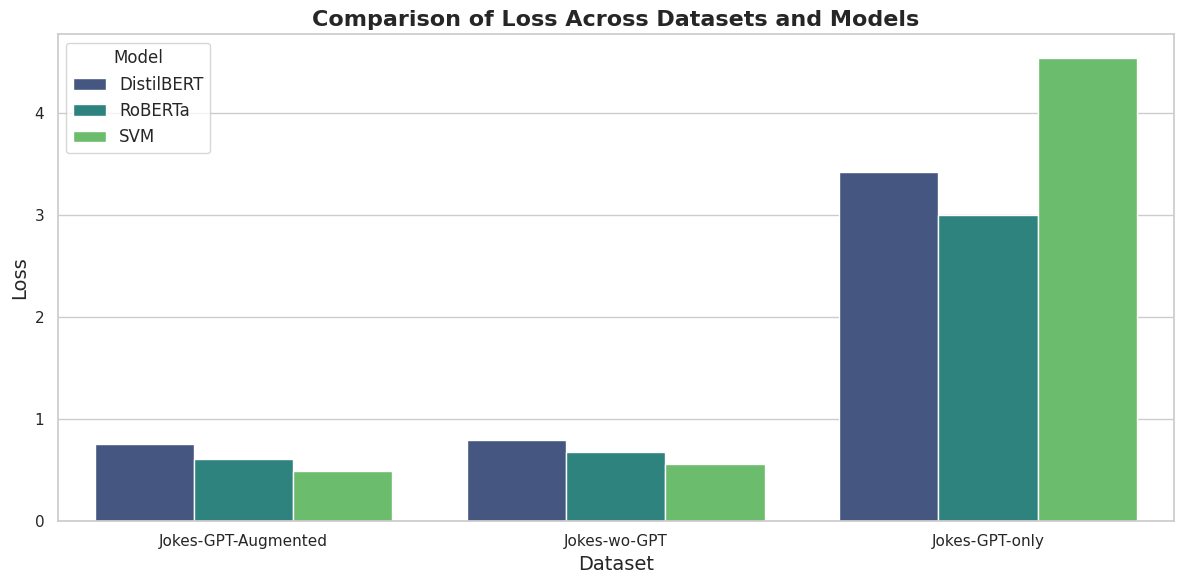

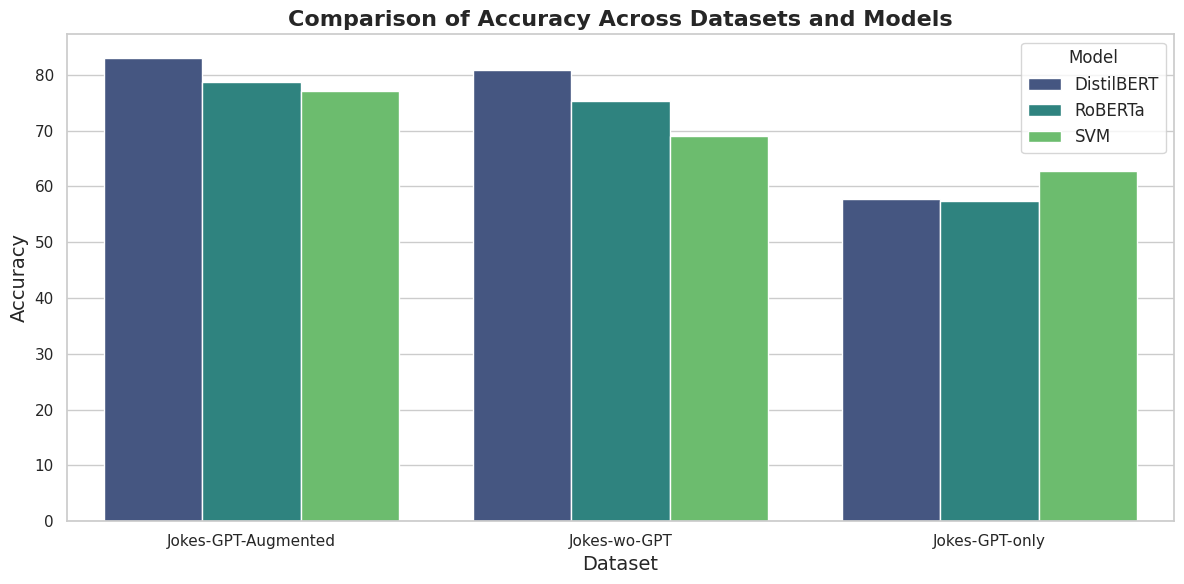

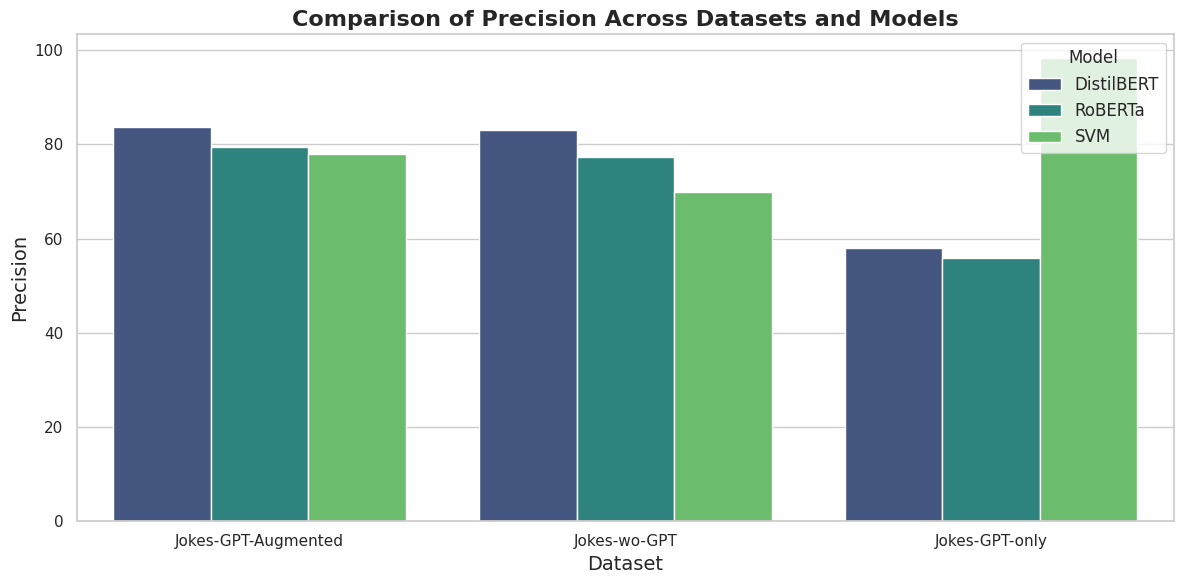

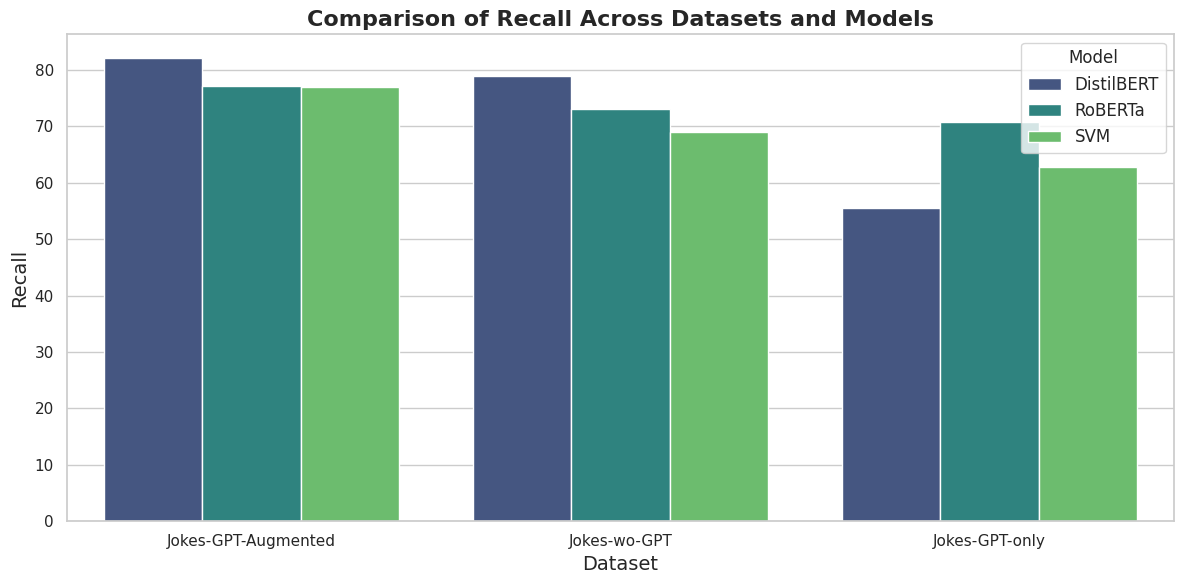

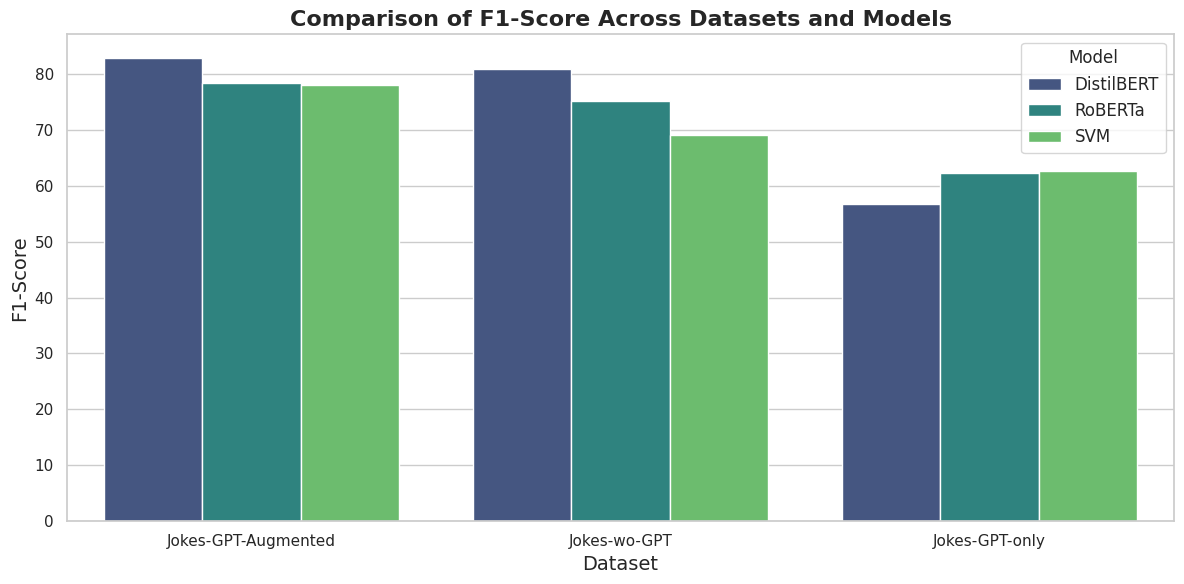

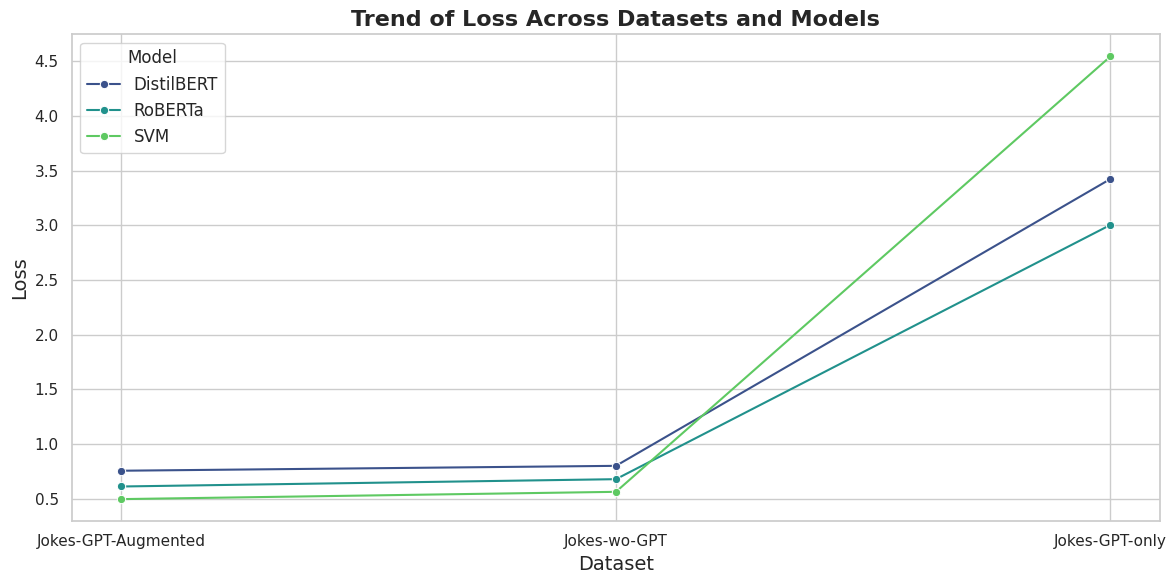

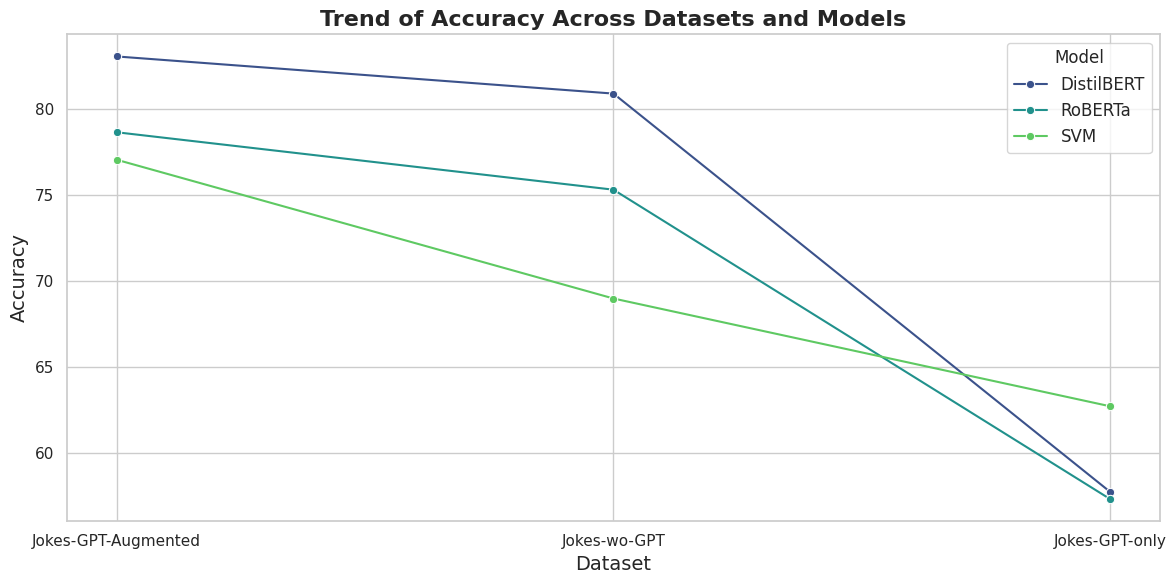

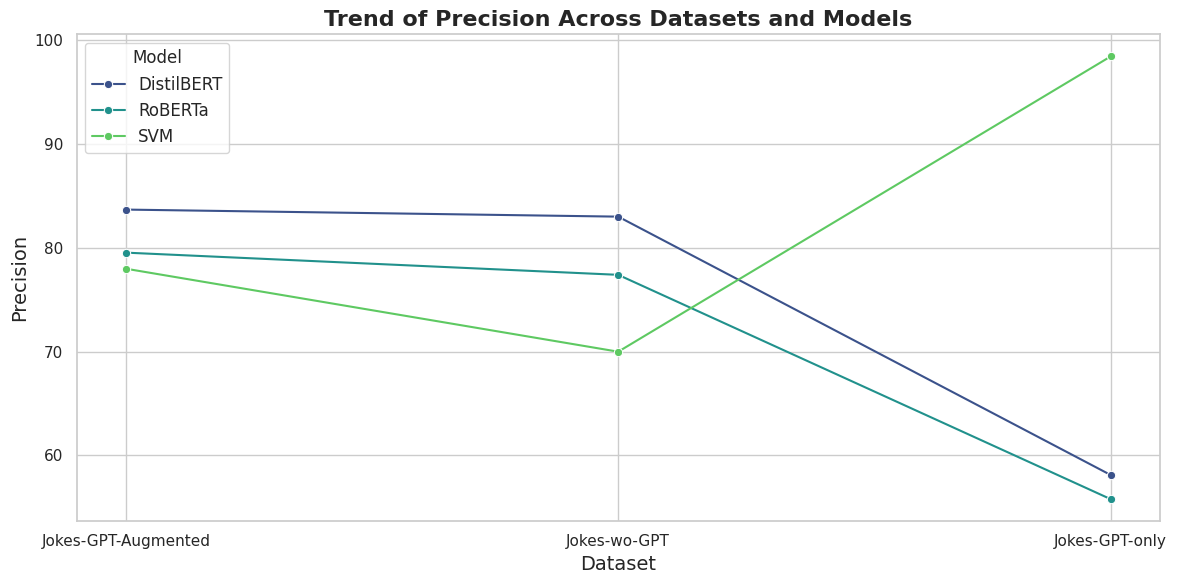

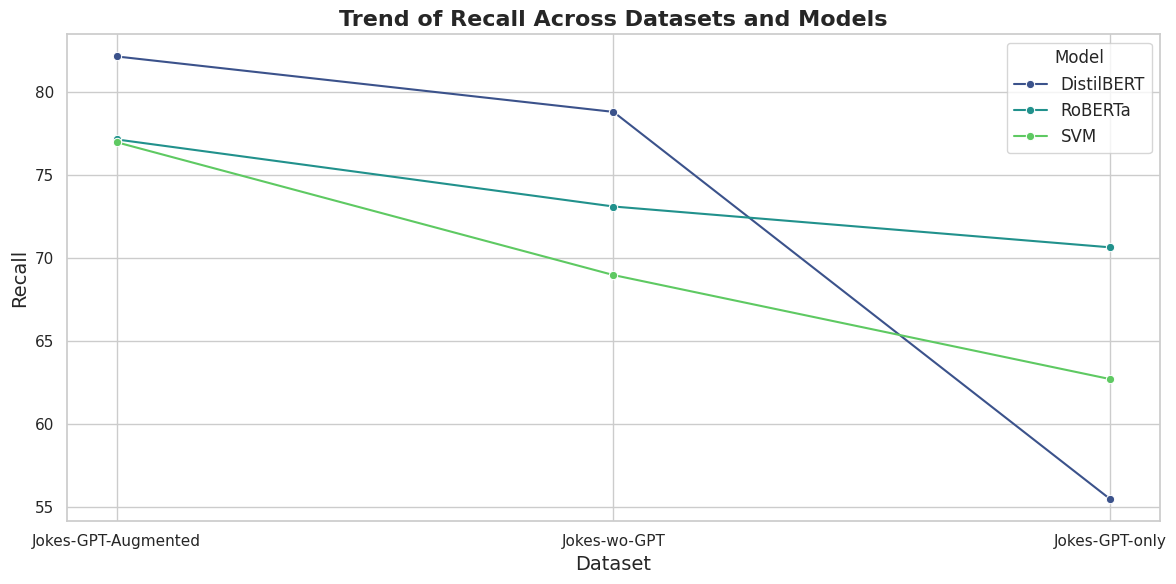

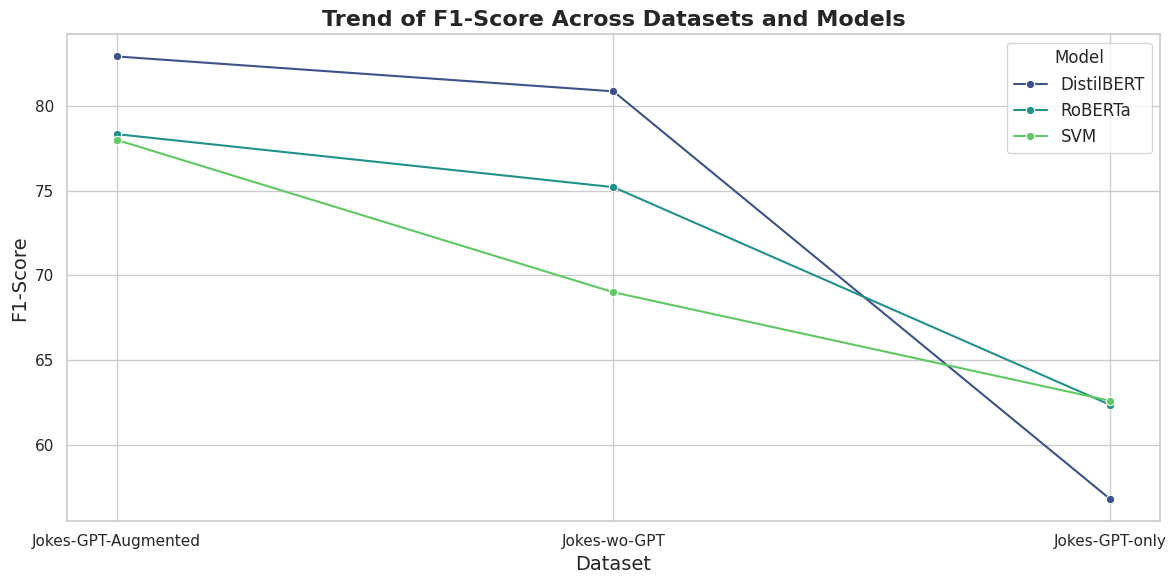

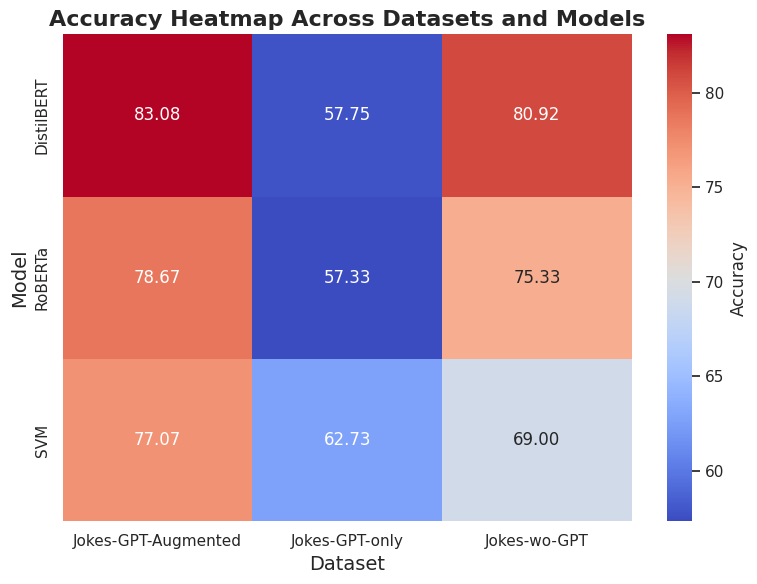

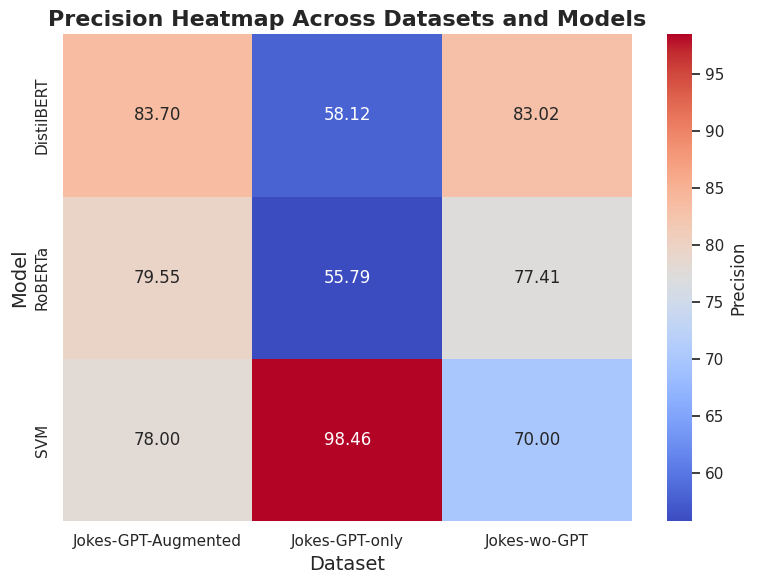

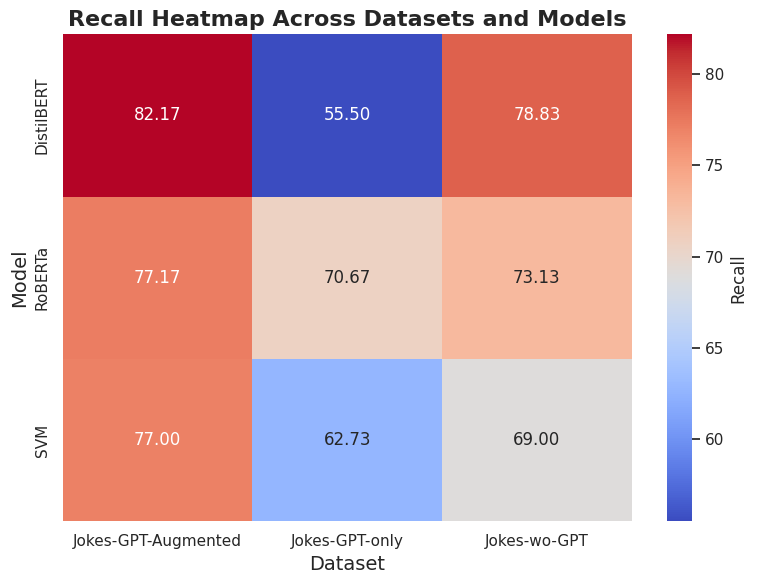

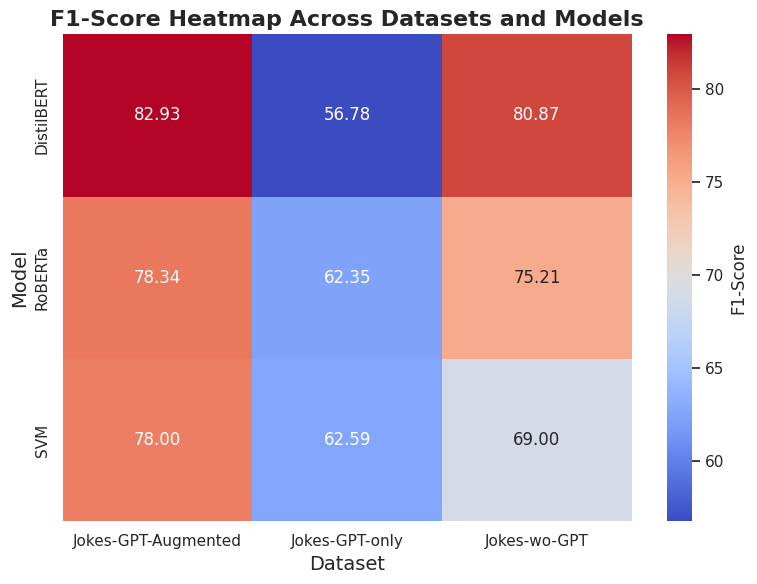

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Updated data from the provided table
data = {
    'Dataset': [
        'Jokes-GPT-Augmented', 'Jokes-GPT-Augmented', 'Jokes-GPT-Augmented',
        'Jokes-wo-GPT', 'Jokes-wo-GPT', 'Jokes-wo-GPT',
        'Jokes-GPT-only', 'Jokes-GPT-only', 'Jokes-GPT-only'
    ],
    'Model': [
        'DistilBERT', 'RoBERTa', 'SVM',
        'DistilBERT', 'RoBERTa', 'SVM',
        'DistilBERT', 'RoBERTa', 'SVM'
    ],
    'Loss': [0.7543, 0.6101, 0.4946, 0.7990, 0.6770, 0.5613, 3.423, 3.003, 4.544],
    'Accuracy': [83.08, 78.67, 77.07, 80.92, 75.33, 69.00, 57.75, 57.33, 62.73],
    'Precision': [83.70, 79.55, 78.00, 83.02, 77.41, 70.00, 58.12, 55.79, 98.46],
    'Recall': [82.17, 77.17, 77.00, 78.83, 73.13, 69.00, 55.50, 70.67, 62.73],
    'F1-Score': [82.93, 78.34, 78.00, 80.87, 75.21, 69.00, 56.78, 62.35, 62.59]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Set Seaborn style
sns.set_theme(style="whitegrid")

# List of metrics to visualize
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

# Bar Chart Visualization for Metrics Comparison
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Dataset', y=metric, hue='Model', data=df, palette='viridis')
    plt.title(f"Comparison of {metric} Across Datasets and Models", fontsize=16, fontweight='bold')
    plt.ylabel(metric, fontsize=14)
    plt.xlabel("Dataset", fontsize=14)
    plt.legend(title="Model", loc="best", fontsize=12)
    plt.tight_layout()
    plt.show()

# Line Chart Visualization for Trends
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Dataset', y=metric, hue='Model', data=df, marker="o", palette='viridis')
    plt.title(f"Trend of {metric} Across Datasets and Models", fontsize=16, fontweight='bold')
    plt.ylabel(metric, fontsize=14)
    plt.xlabel("Dataset", fontsize=14)
    plt.legend(title="Model", loc="best", fontsize=12)
    plt.tight_layout()
    plt.show()

# Heatmap for Accuracy, Precision, Recall, and F1-Score
metrics_subset = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for metric in metrics_subset:
    pivot_table = df.pivot_table(index='Model', columns='Dataset', values=metric)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': metric})
    plt.title(f"{metric} Heatmap Across Datasets and Models", fontsize=16, fontweight='bold')
    plt.ylabel("Model", fontsize=14)
    plt.xlabel("Dataset", fontsize=14)
    plt.tight_layout()
    plt.show()


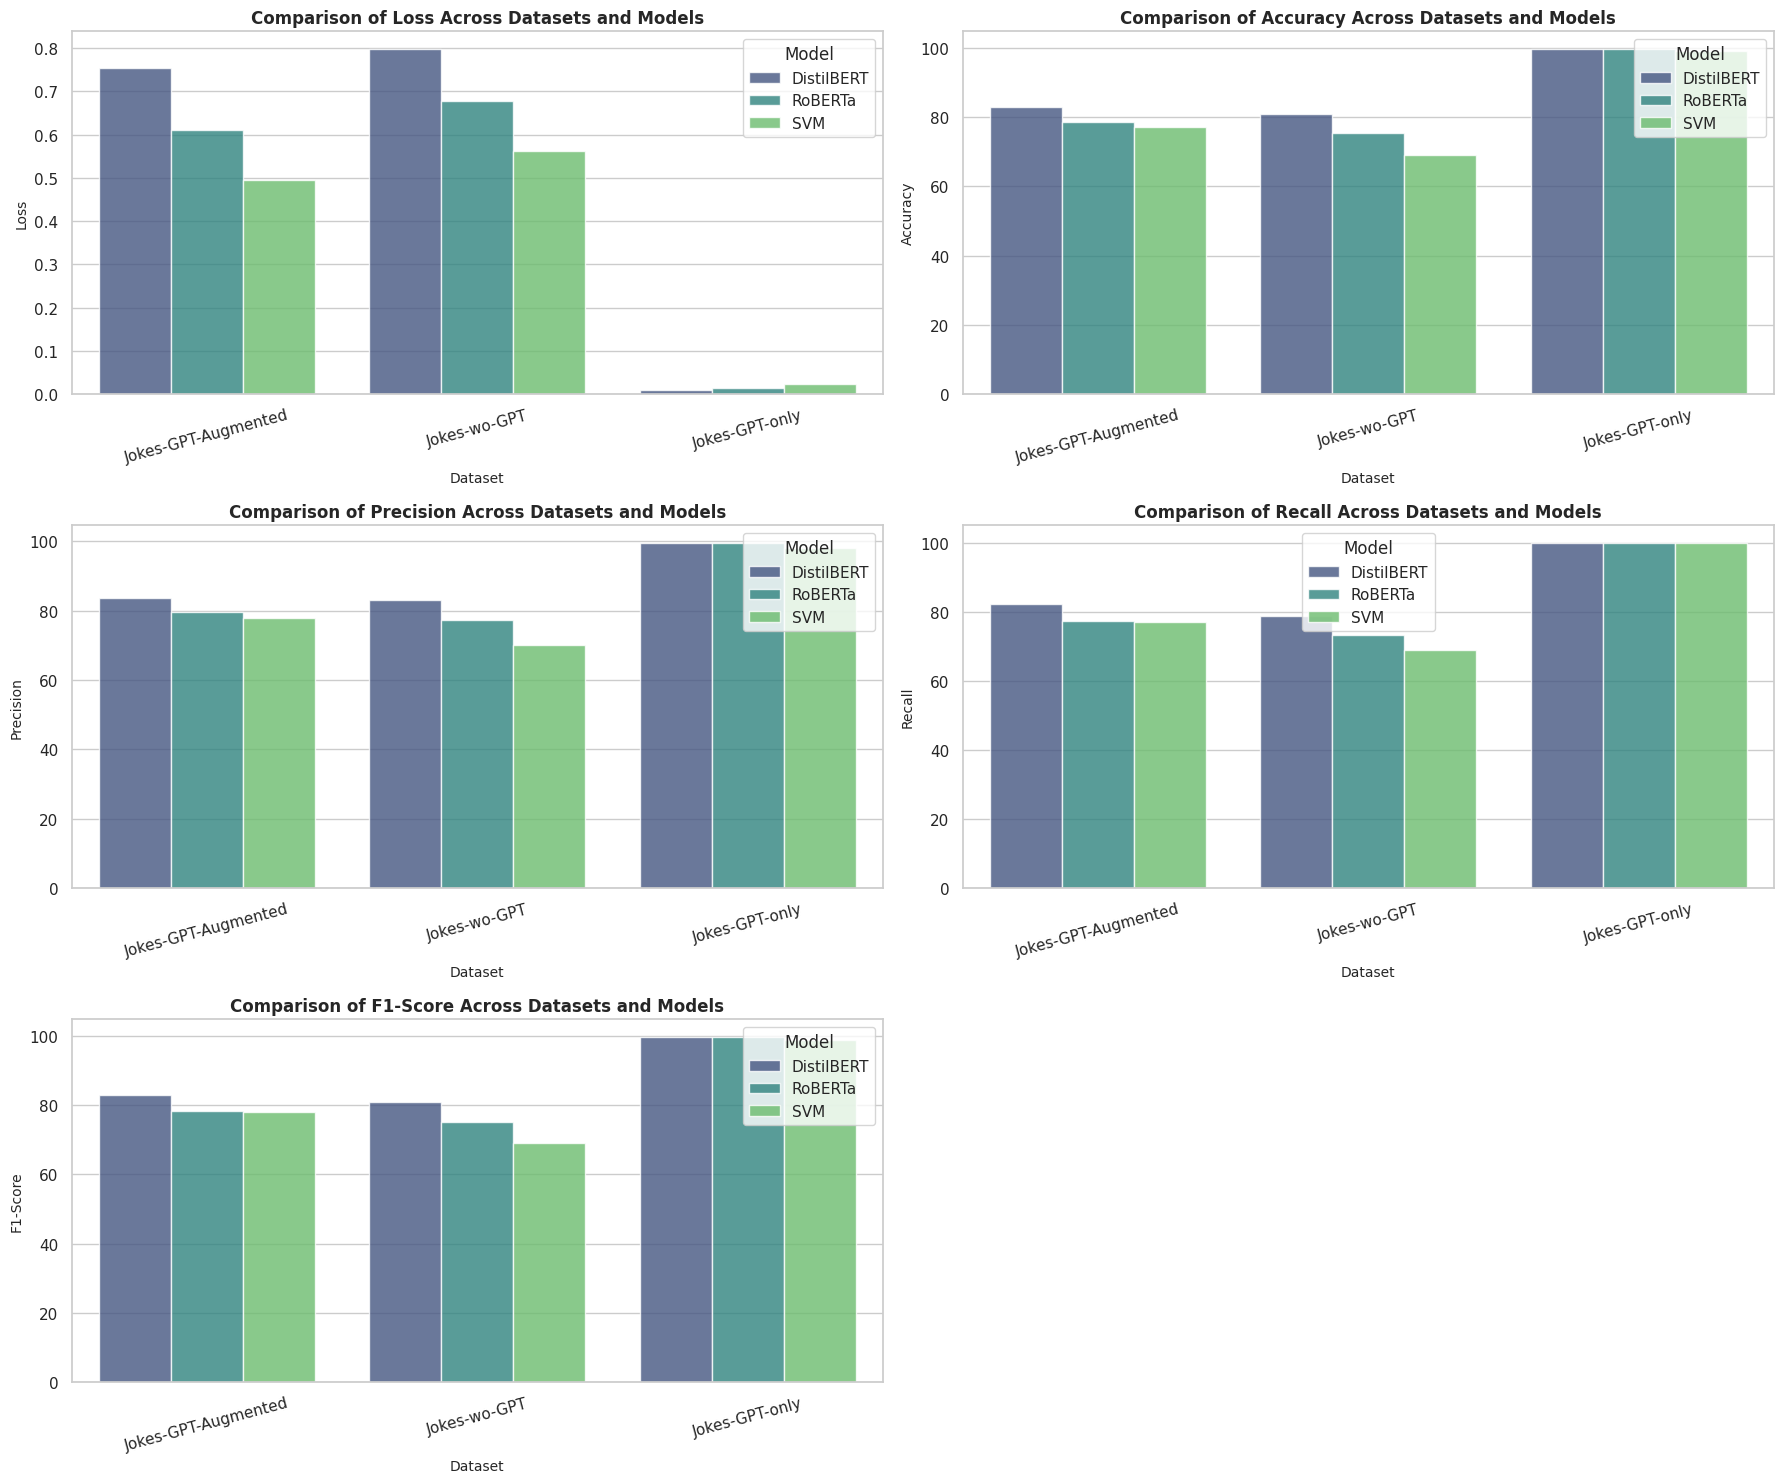

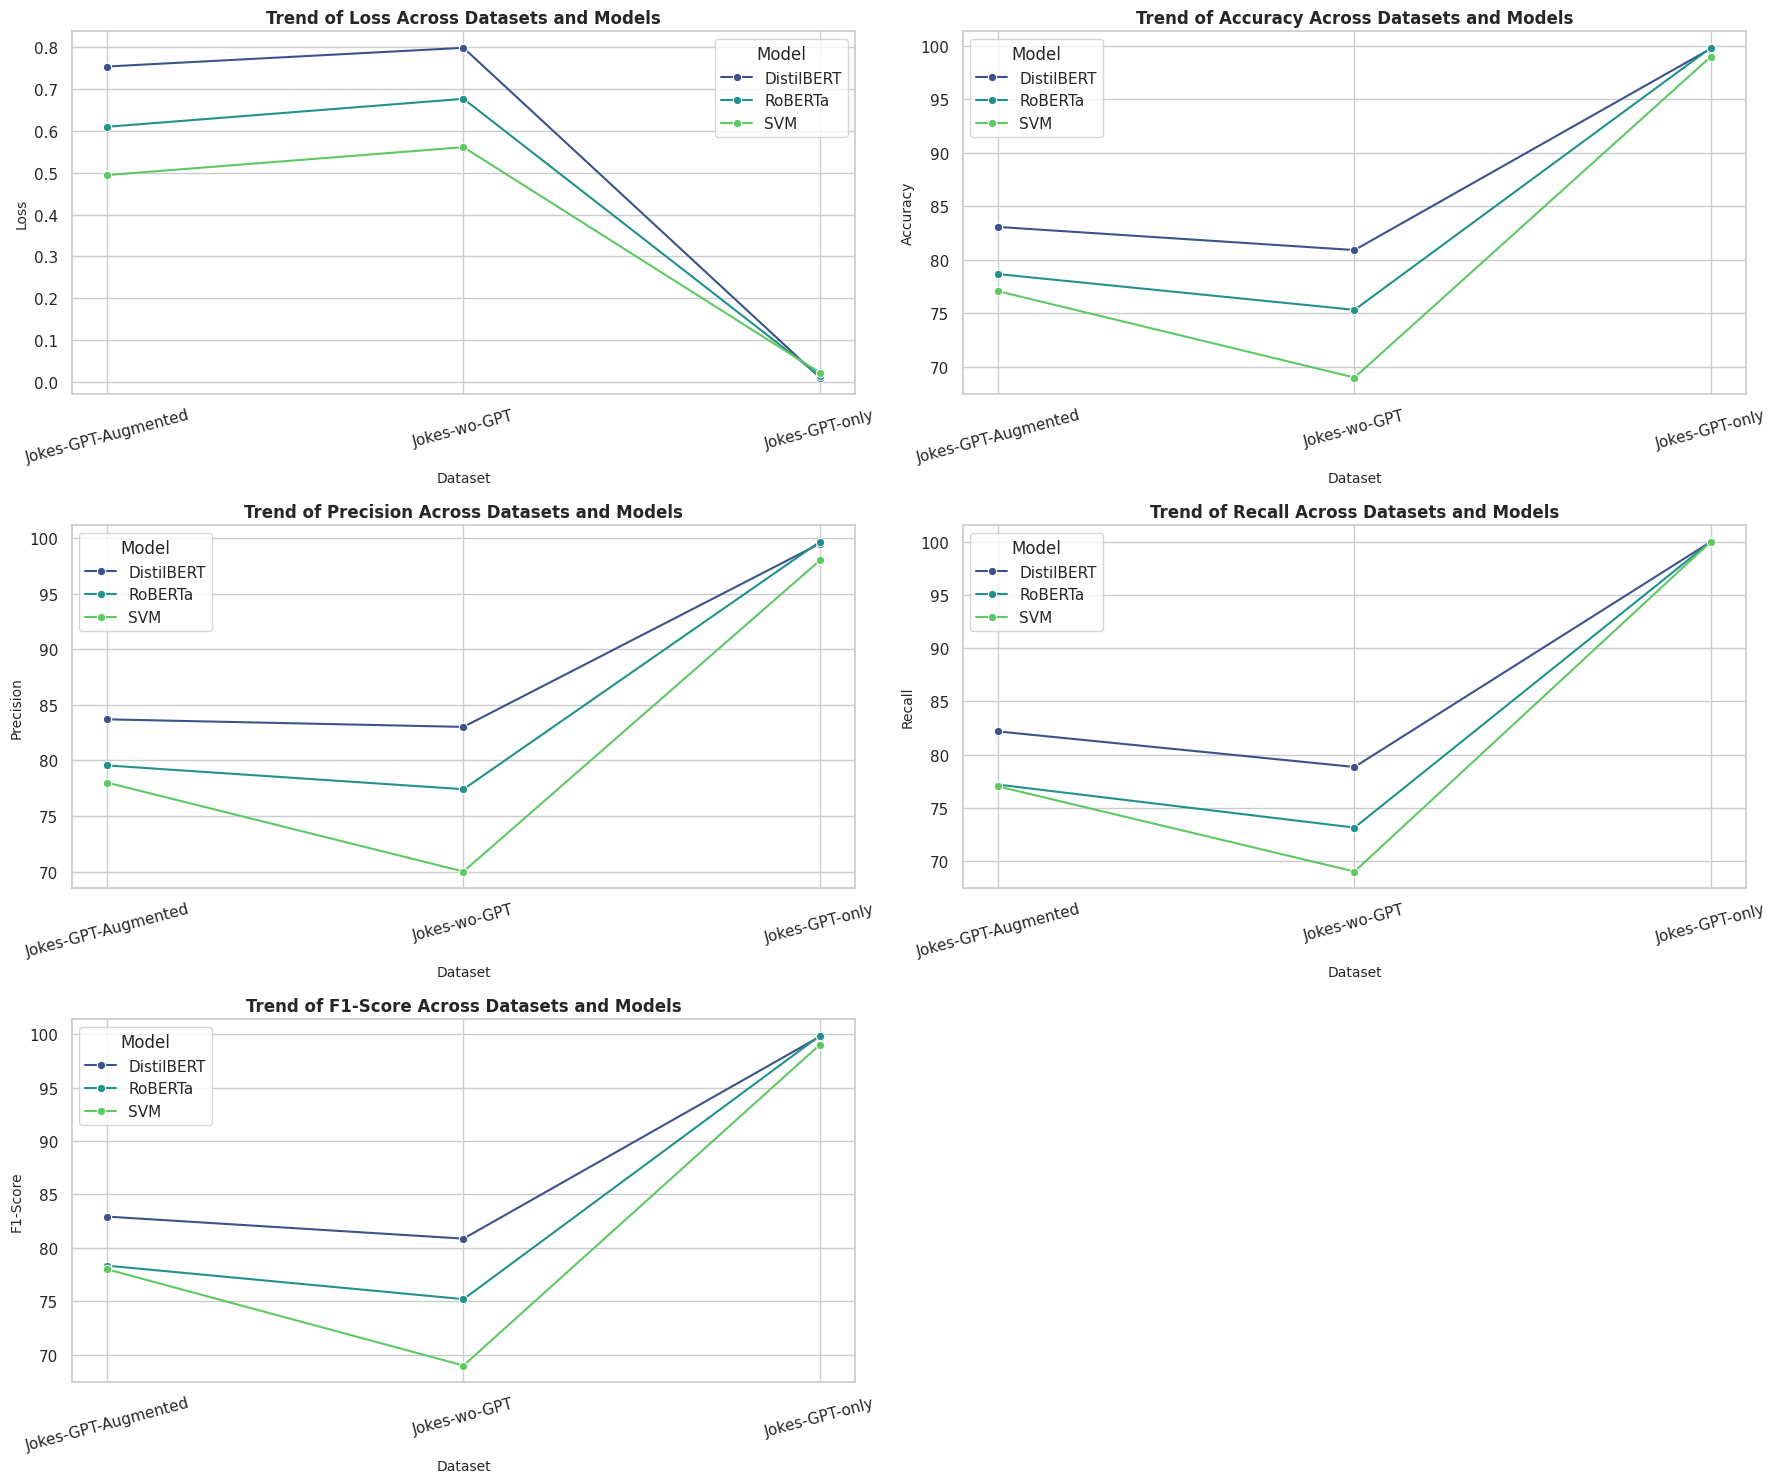

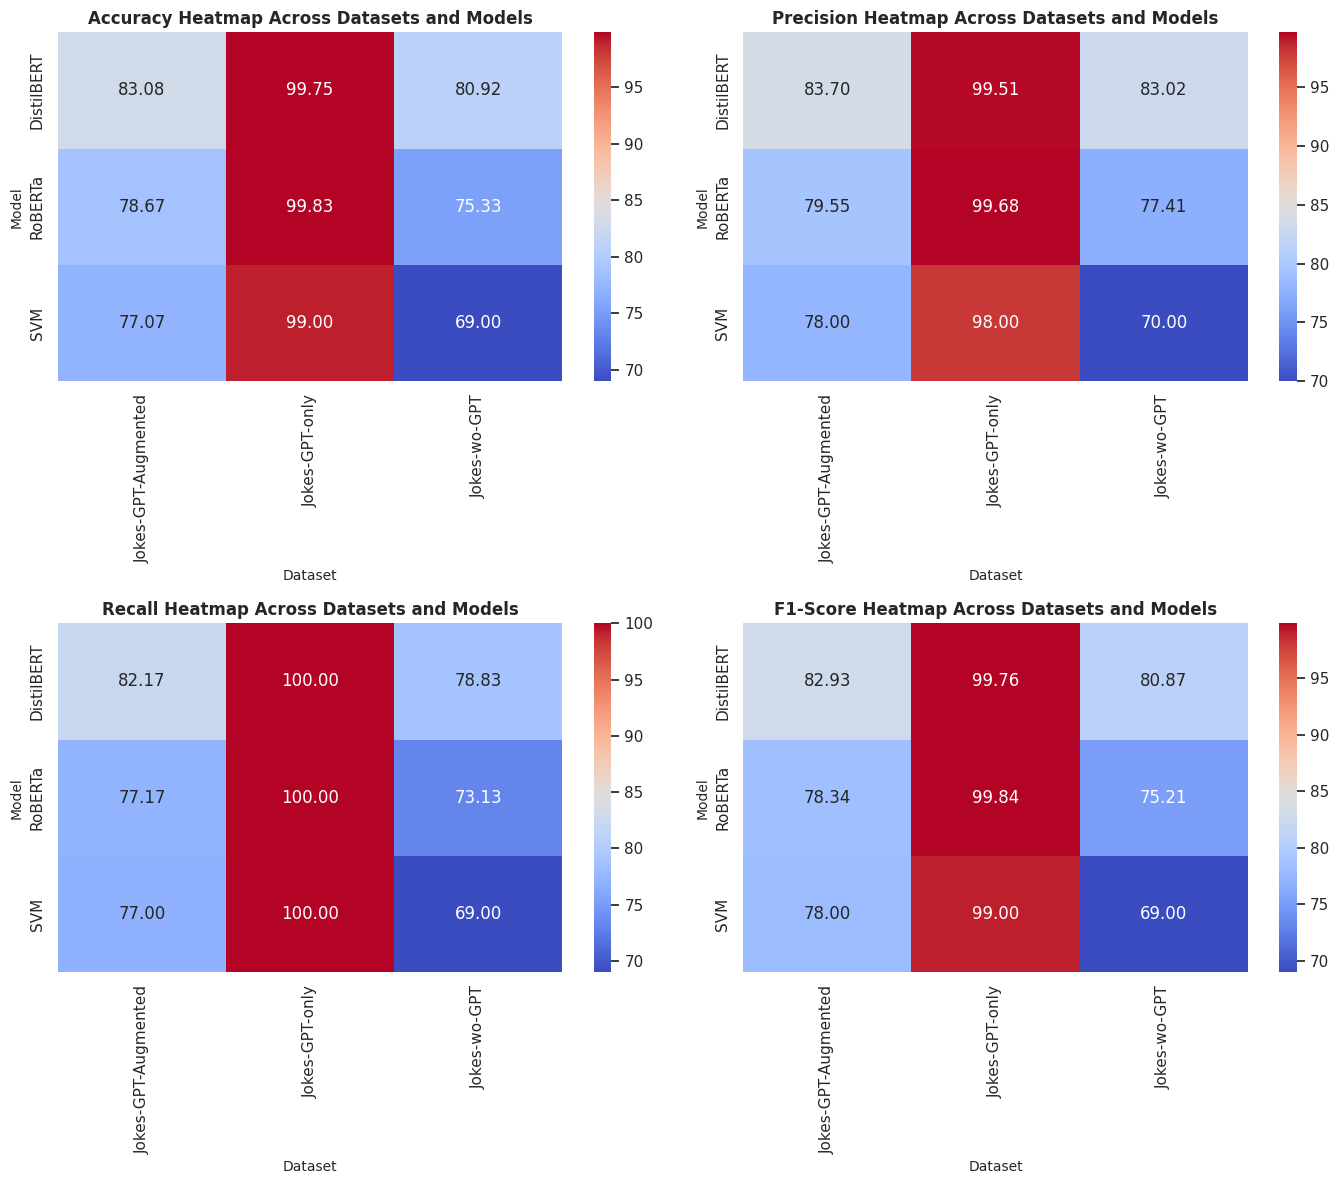

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Updated data from your table
data = {
    'Dataset': [
        'Jokes-GPT-Augmented', 'Jokes-GPT-Augmented', 'Jokes-GPT-Augmented',
        'Jokes-wo-GPT', 'Jokes-wo-GPT', 'Jokes-wo-GPT',
        'Jokes-GPT-only', 'Jokes-GPT-only', 'Jokes-GPT-only'
    ],
    'Model': [
        'DistilBERT', 'RoBERTa', 'SVM',
        'DistilBERT', 'RoBERTa', 'SVM',
        'DistilBERT', 'RoBERTa', 'SVM'
    ],
    'Loss': [0.7543, 0.6101, 0.4946, 0.7990, 0.6770, 0.5613, 0.0102, 0.0142, 0.0222],
    'Accuracy': [83.08, 78.67, 77.07, 80.92, 75.33, 69.00, 99.75, 99.83, 99.00],
    'Precision': [83.70, 79.55, 78.00, 83.02, 77.41, 70.00, 99.51, 99.68, 98.00],
    'Recall': [82.17, 77.17, 77.00, 78.83, 73.13, 69.00, 100.00, 100.00, 100.00],
    'F1-Score': [82.93, 78.34, 78.00, 80.87, 75.21, 69.00, 99.76, 99.84, 99.00]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Metrics to visualize
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

# **Figure 1: Combined Bar Plots for Metrics**
fig1, axes1 = plt.subplots(3, 2, figsize=(18, 15))
axes1 = axes1.flatten()

for i, metric in enumerate(metrics):
    sns.barplot(x='Dataset', y=metric, hue='Model', data=df, ax=axes1[i], palette='viridis', alpha=0.8)
    axes1[i].set_title(f"Comparison of {metric} Across Datasets and Models", fontsize=12, fontweight='bold')
    axes1[i].set_ylabel(metric, fontsize=10)
    axes1[i].set_xlabel("Dataset", fontsize=10)
    axes1[i].tick_params(axis='x', rotation=15)

# Remove unused subplot if metrics < total axes
for j in range(len(metrics), len(axes1)):
    fig1.delaxes(axes1[j])

fig1.tight_layout()
plt.show()

# **Figure 2: Combined Line Plots for Trends**
fig2, axes2 = plt.subplots(3, 2, figsize=(18, 15))
axes2 = axes2.flatten()

for i, metric in enumerate(metrics):
    sns.lineplot(x='Dataset', y=metric, hue='Model', data=df, ax=axes2[i], marker="o", palette='viridis')
    axes2[i].set_title(f"Trend of {metric} Across Datasets and Models", fontsize=12, fontweight='bold')
    axes2[i].set_ylabel(metric, fontsize=10)
    axes2[i].set_xlabel("Dataset", fontsize=10)
    axes2[i].tick_params(axis='x', rotation=15)

# Remove unused subplot if metrics < total axes
for j in range(len(metrics), len(axes2)):
    fig2.delaxes(axes2[j])

fig2.tight_layout()
plt.show()

# **Figure 3: Heatmaps for Metrics**
fig3, axes3 = plt.subplots(2, 2, figsize=(14, 12))
heatmap_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, metric in enumerate(heatmap_metrics):
    heatmap_data = df.pivot_table(values=metric, index='Model', columns='Dataset', aggfunc='mean')
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='coolwarm', ax=axes3.flatten()[i])
    axes3.flatten()[i].set_title(f"{metric} Heatmap Across Datasets and Models", fontsize=12, fontweight='bold')
    axes3.flatten()[i].set_xlabel("Dataset", fontsize=10)
    axes3.flatten()[i].set_ylabel("Model", fontsize=10)

# Remove unused subplot if heatmap_metrics < total axes
for j in range(len(heatmap_metrics), len(axes3.flatten())):
    fig3.delaxes(axes3.flatten()[j])

fig3.tight_layout()
plt.show()


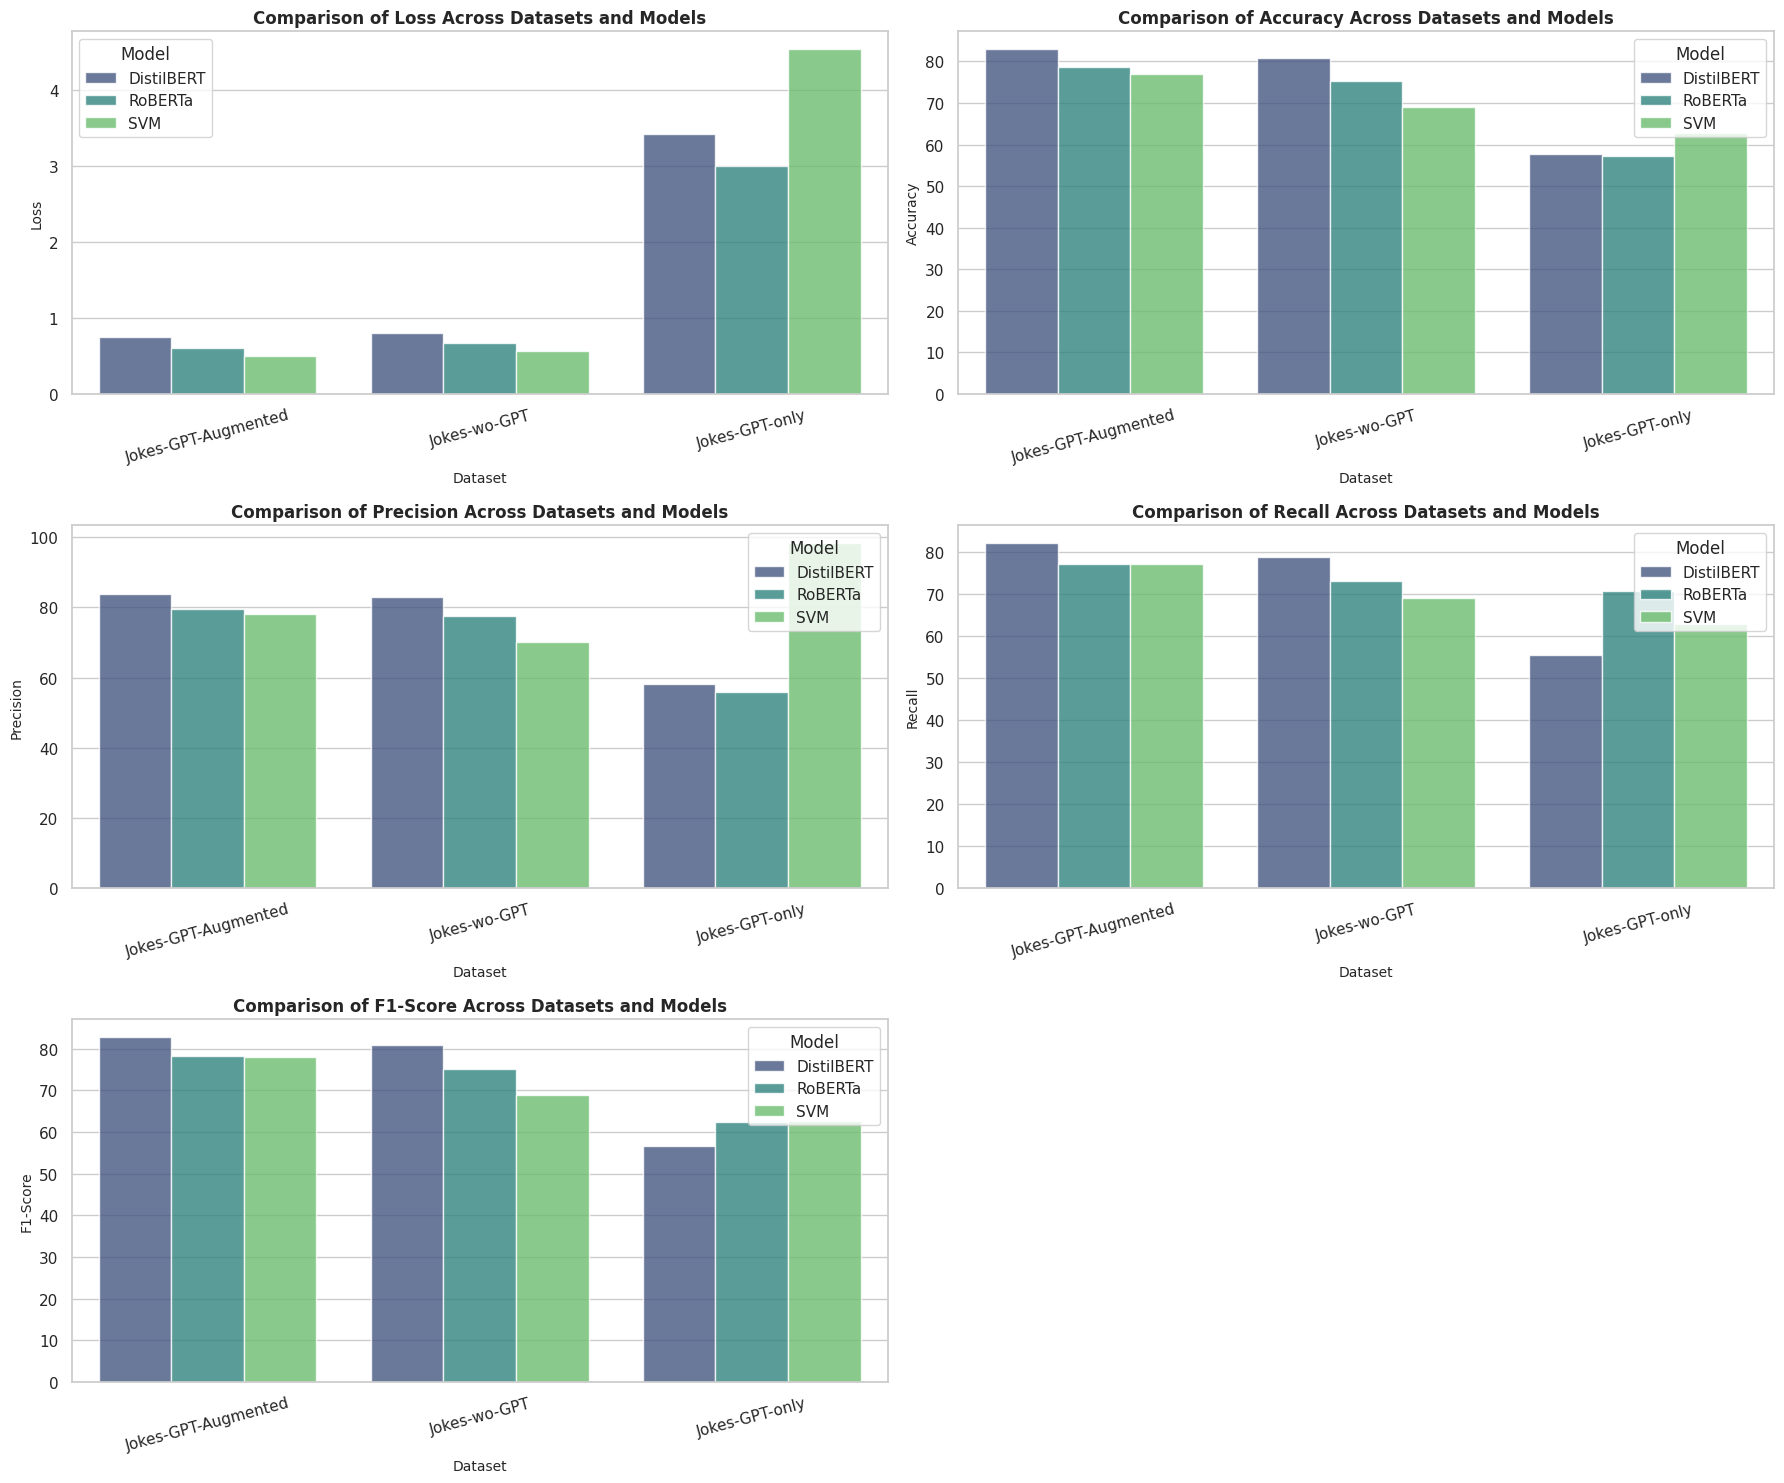

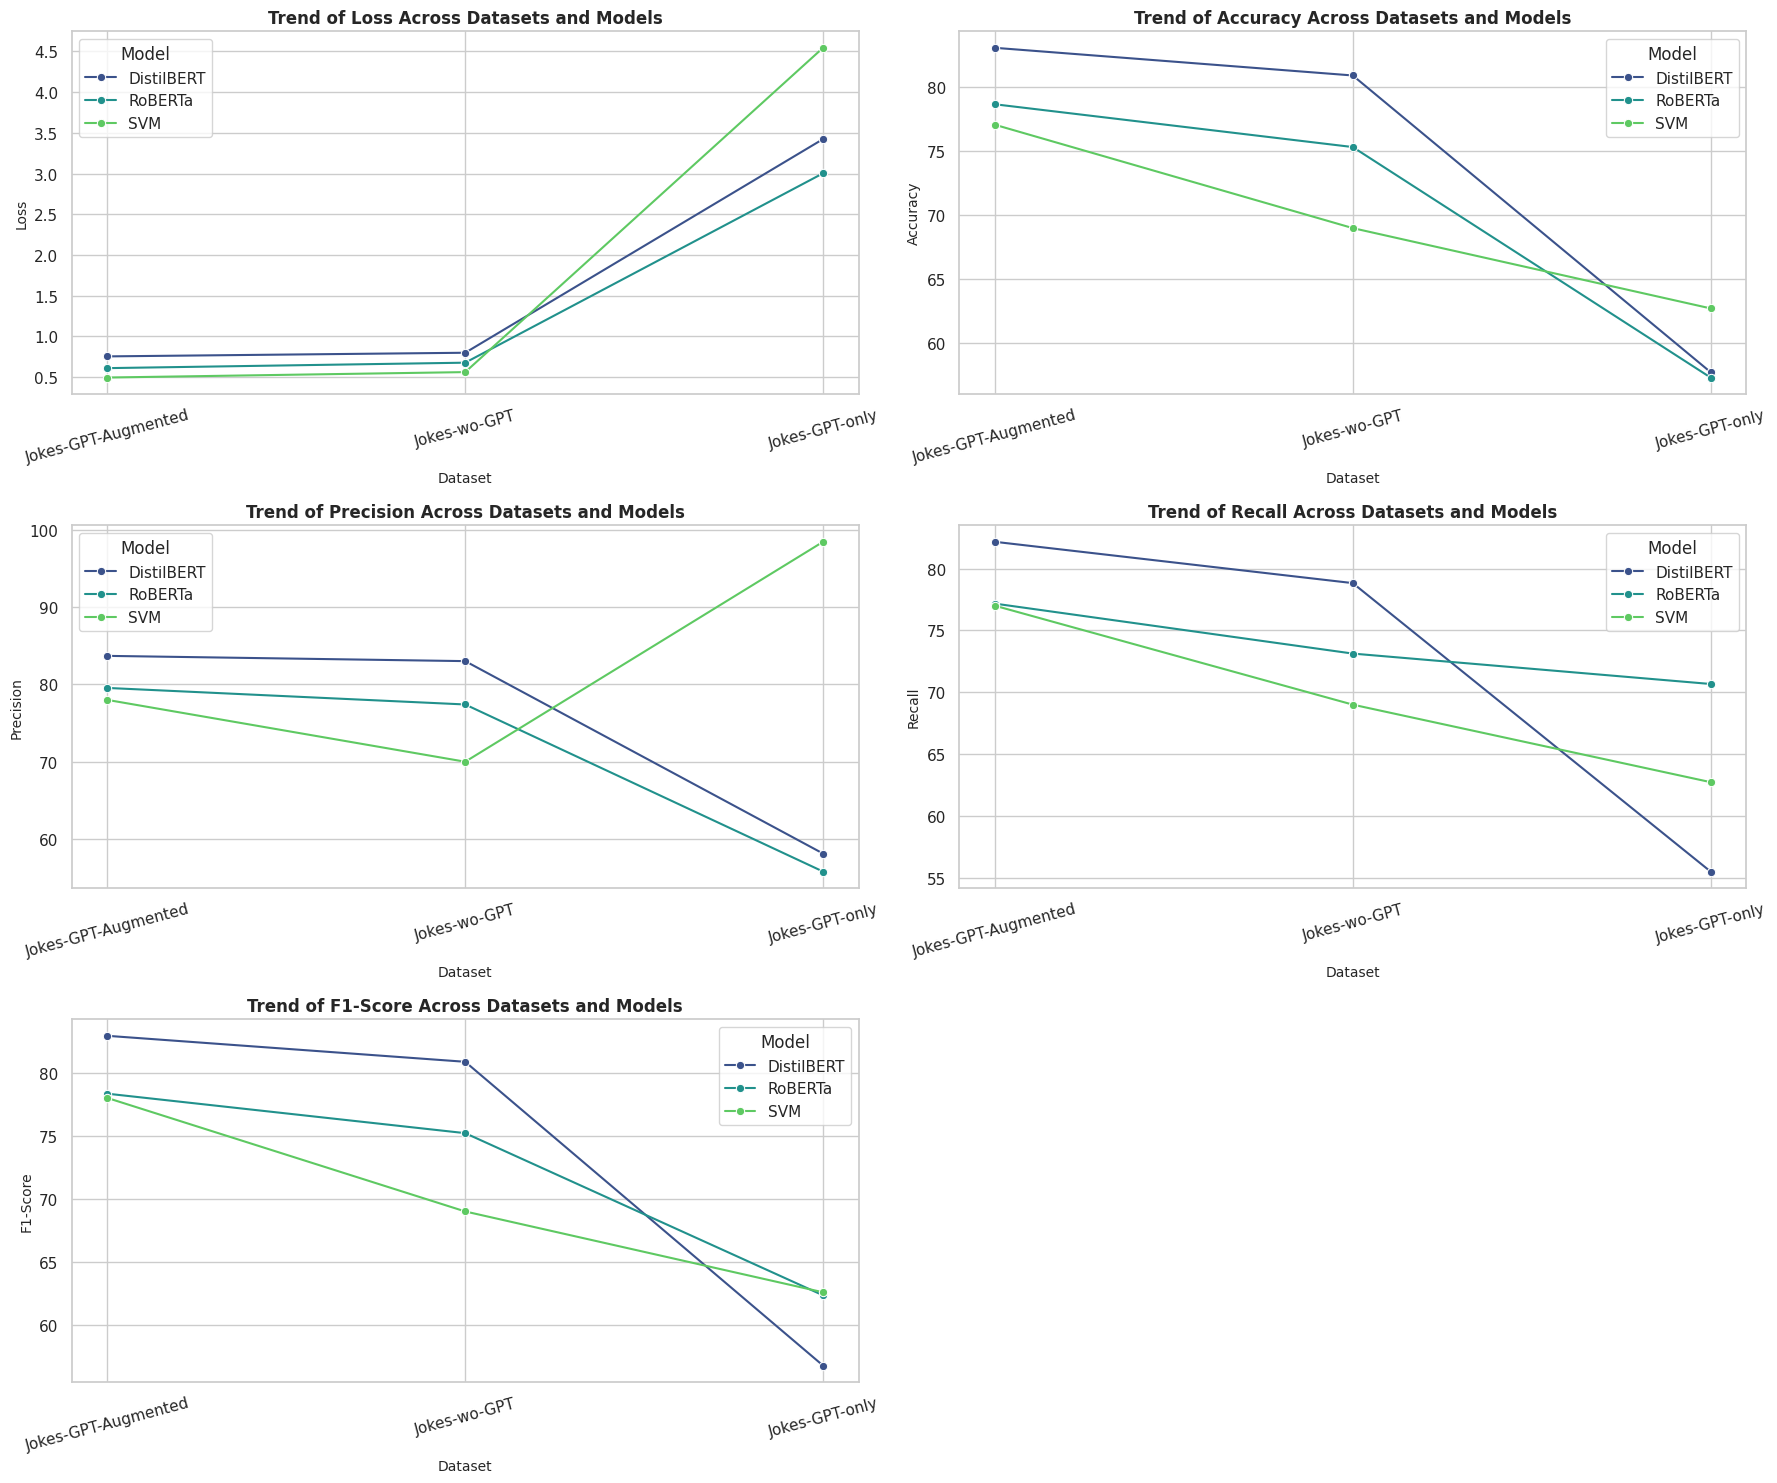

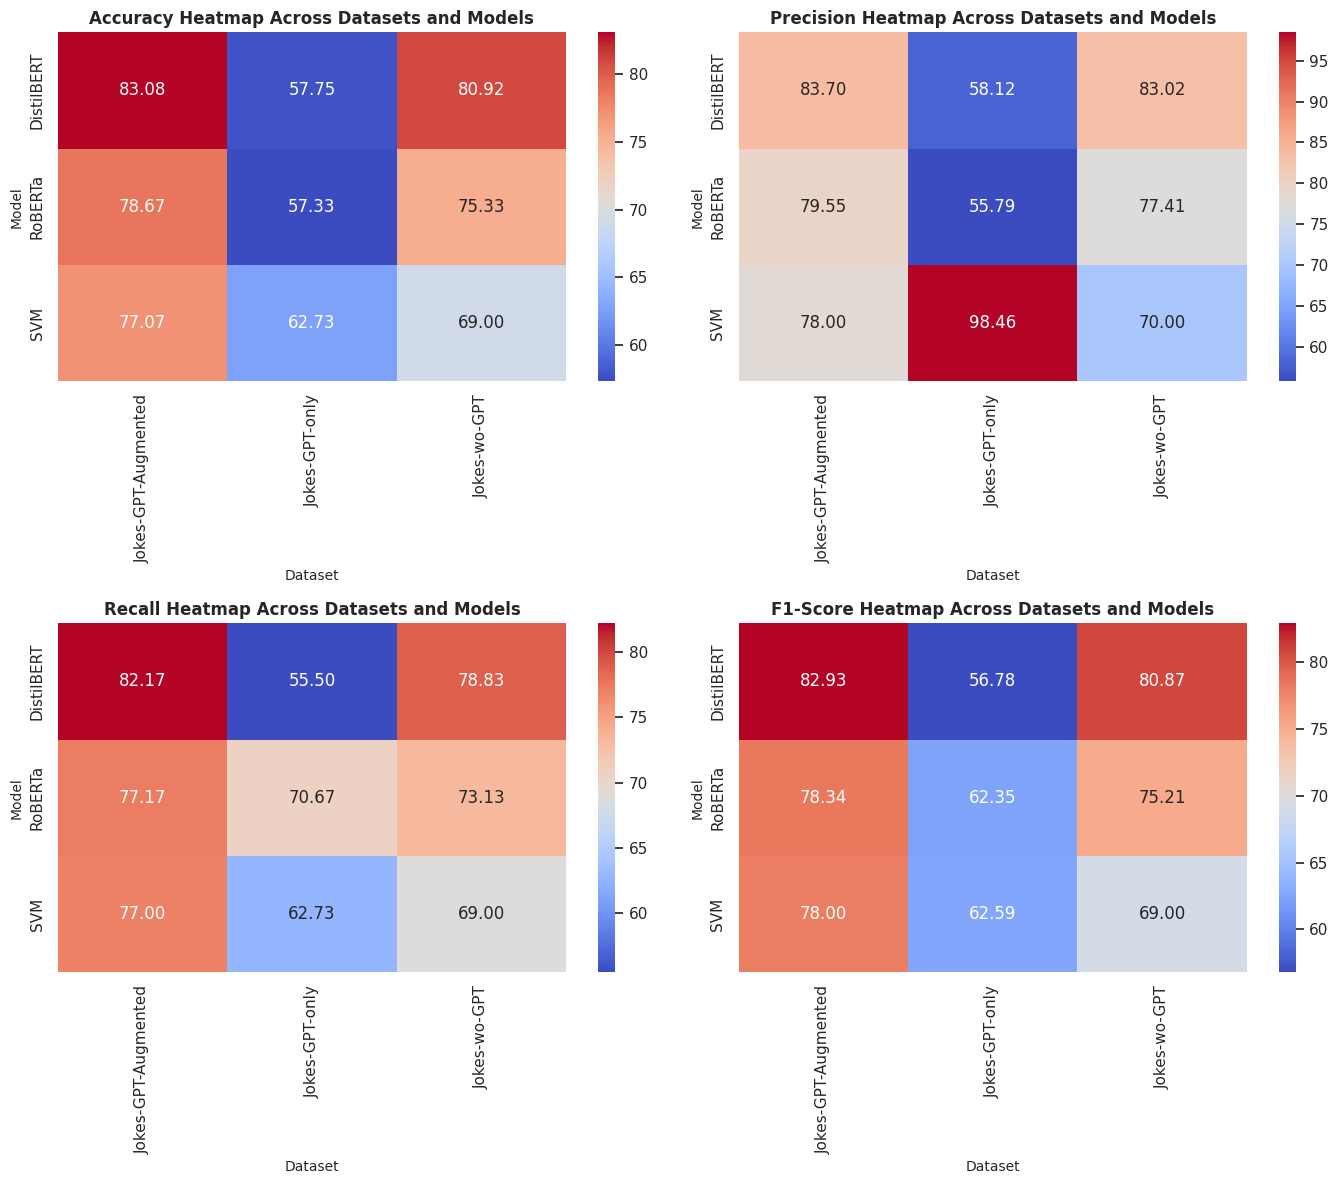

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Updated data from your table
data = {
    'Dataset': [
        'Jokes-GPT-Augmented', 'Jokes-GPT-Augmented', 'Jokes-GPT-Augmented',
        'Jokes-wo-GPT', 'Jokes-wo-GPT', 'Jokes-wo-GPT',
        'Jokes-GPT-only', 'Jokes-GPT-only', 'Jokes-GPT-only'
    ],
    'Model': [
        'DistilBERT', 'RoBERTa', 'SVM',
        'DistilBERT', 'RoBERTa', 'SVM',
        'DistilBERT', 'RoBERTa', 'SVM'
    ],
    'Loss': [0.7543, 0.6101, 0.4946, 0.7990, 0.6770, 0.5613, 3.423, 3.003, 4.544],
    'Accuracy': [83.08, 78.67, 77.07, 80.92, 75.33, 69.00, 57.75, 57.33, 62.73],
    'Precision': [83.70, 79.55, 78.00, 83.02, 77.41, 70.00, 58.12, 55.79, 98.46],
    'Recall': [82.17, 77.17, 77.00, 78.83, 73.13, 69.00, 55.50, 70.67, 62.73],
    'F1-Score': [82.93, 78.34, 78.00, 80.87, 75.21, 69.00, 56.78, 62.35, 62.59]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Metrics to visualize
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-Score']

# **Figure 1: Combined Bar Plots for Metrics**
fig1, axes1 = plt.subplots(3, 2, figsize=(18, 15))
axes1 = axes1.flatten()

for i, metric in enumerate(metrics):
    sns.barplot(x='Dataset', y=metric, hue='Model', data=df, ax=axes1[i], palette='viridis', alpha=0.8)
    axes1[i].set_title(f"Comparison of {metric} Across Datasets and Models", fontsize=12, fontweight='bold')
    axes1[i].set_ylabel(metric, fontsize=10)
    axes1[i].set_xlabel("Dataset", fontsize=10)
    axes1[i].tick_params(axis='x', rotation=15)

# Remove unused subplot if metrics < total axes
for j in range(len(metrics), len(axes1)):
    fig1.delaxes(axes1[j])

fig1.tight_layout()
plt.show()

# **Figure 2: Combined Line Plots for Trends**
fig2, axes2 = plt.subplots(3, 2, figsize=(18, 15))
axes2 = axes2.flatten()

for i, metric in enumerate(metrics):
    sns.lineplot(x='Dataset', y=metric, hue='Model', data=df, ax=axes2[i], marker="o", palette='viridis')
    axes2[i].set_title(f"Trend of {metric} Across Datasets and Models", fontsize=12, fontweight='bold')
    axes2[i].set_ylabel(metric, fontsize=10)
    axes2[i].set_xlabel("Dataset", fontsize=10)
    axes2[i].tick_params(axis='x', rotation=15)

# Remove unused subplot if metrics < total axes
for j in range(len(metrics), len(axes2)):
    fig2.delaxes(axes2[j])

fig2.tight_layout()
plt.show()

# **Figure 3: Heatmaps for Metrics**
fig3, axes3 = plt.subplots(2, 2, figsize=(14, 12))
heatmap_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, metric in enumerate(heatmap_metrics):
    heatmap_data = df.pivot_table(values=metric, index='Model', columns='Dataset', aggfunc='mean')
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='coolwarm', ax=axes3.flatten()[i])
    axes3.flatten()[i].set_title(f"{metric} Heatmap Across Datasets and Models", fontsize=12, fontweight='bold')
    axes3.flatten()[i].set_xlabel("Dataset", fontsize=10)
    axes3.flatten()[i].set_ylabel("Model", fontsize=10)
    #axes3[i].tick_params(axis='x', rotation=15)

# Remove unused subplot if heatmap_metrics < total axes
for j in range(len(heatmap_metrics), len(axes3.flatten())):
    fig3.delaxes(axes3.flatten()[j])

fig3.tight_layout()
plt.show()


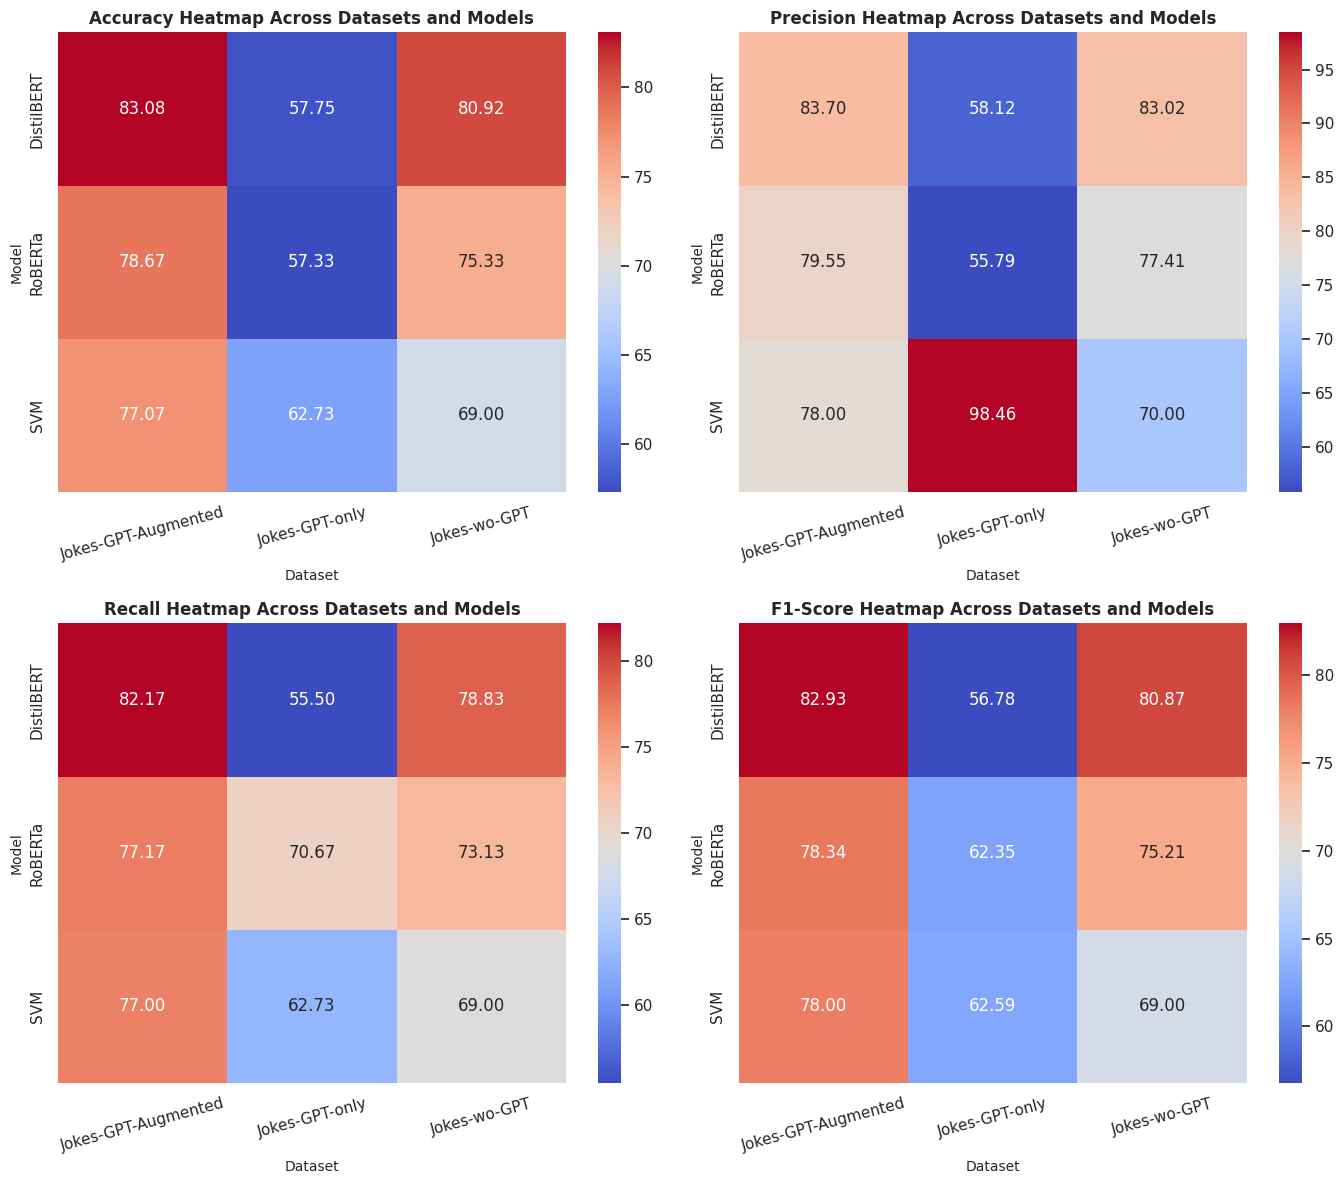

In [3]:
# **Figure 3: Heatmaps for Metrics**
fig3, axes3 = plt.subplots(2, 2, figsize=(14, 12))
axes3 = axes3.flatten()
heatmap_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']


for i, metric in enumerate(heatmap_metrics):
    heatmap_data = df.pivot_table(values=metric, index='Model', columns='Dataset', aggfunc='mean')
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='coolwarm', ax=axes3.flatten()[i])
    axes3.flatten()[i].set_title(f"{metric} Heatmap Across Datasets and Models", fontsize=12, fontweight='bold')
    axes3.flatten()[i].set_xlabel("Dataset", fontsize=10)
    axes3.flatten()[i].set_ylabel("Model", fontsize=10)
    axes3[i].tick_params(axis='x', rotation=15)

# Remove unused subplot if heatmap_metrics < total axes
for j in range(len(heatmap_metrics), len(axes3.flatten())):
    fig3.delaxes(axes3.flatten()[j])

fig3.tight_layout()
plt.show()